# **Gridspace-Stanford Harper Valley Bank dataset**

This notebook focuses on the use of the Gridspace-Stanford Harper Valley dataset and in building models for tasks such as Speech-to-Text, Chatbot, Text-to-Speech and classification on this dataset.  
Work by:  
-Liborio ROMAN  
-Niccolò GRILLO  
-Gabriele FARACE  
-Eddie NEVANDER HELLSTRÖM  
-Andrés Emiliano ESCOBEDO GORDILLO  

**Optional for Colab users**

In [ ]:
import os
from google.colab import drive

# # Mount drive and change directory
drive.mount('/content/drive')
path = 'NLP-Project'

os.chdir(f'/content/drive/MyDrive/{path}')
os.getcwd()

Mounted at /content/drive


'/content/drive/MyDrive/NLP-Project'

In [ ]:
%%capture
!pip install datasets
!pip install nltk
!pip install transformers
!pip install --upgrade accelerate
!pip install jiwer
!pip3 install torch
!pip3 install --upgrade scikit-learn==1.0.2
!pip3 install matplotlib
!pip3 install accelerate -U
!pip3 install evaluate
!pip install --upgrade gensim
!pip install soundfile wave torchaudio
!pip install ffmpeg-python
!pip install speechbrain
!pip install plotly

## Dataset Exploration

In this section we extract the relevant data and we explore the dataset. We also focus on embeddings and visualizations.
To run this notebook you need the dataset 'gridspace_repo' in the drive folder called NLP-Project

### Data Retrieval

The information related to the audios are stored in multiple json files, containing:


*   Machine Generated Transcript
*   Human Revised Transcript
*   Dialog Acts
*   Emotion detected (softmax output of a ML classifier)



In [1]:
import json
import pandas as pd

In [ ]:
data = []
datarepo = 'gridspace_repo/data/transcript'
for filename in os.listdir(datarepo):
    if filename.endswith('.json'):
        file_path = os.path.join(datarepo, filename)
        with open(file_path, 'r') as file:
            contents = json.load(file)
            for content in contents:
                emotions = content.get('emotion', {})
                neutral = emotions.get('neutral', None)
                negative = emotions.get('negative', None)
                positive = emotions.get('positive', None)
                data.append({
                    'identifier': filename[:-5],
                    'human_transcript': content['human_transcript'],
                    'machine_transcript': content['transcript'],
                    'dialog_acts': content['dialog_acts'],
                    'emotion_neutral': neutral,
                    'emotion_negative': negative,
                    'emotion_positive': positive,
                    'index': content['index'],
                    'speaker_role': content['speaker_role']
                })
df = pd.DataFrame(data)
df.to_csv('TranscriptDB.csv', index=False)

In [2]:
df = pd.read_csv('TranscriptDB.csv')
df.head(10)

,identifier,human_transcript,machine_transcript,dialog_acts,emotion_neutral,emotion_negative,emotion_positive,index,speaker_role
0,9691bca74ef140d0,hello this is harper valley national bank my n...,hello this is harper valley national bank my n...,['gridspace_greeting'],0.309475,0.015957,0.674568,1,agent
1,9691bca74ef140d0,hi my name is michael williams,hi my name is michael williams,"['gridspace_data_communication', 'gridspace_gr...",0.317042,0.036193,0.646765,2,caller
2,9691bca74ef140d0,i would like to reset my password,i would like to reset my password,"['gridspace_yes_response', 'gridspace_problem_...",0.553823,0.278830,0.167346,3,caller
3,9691bca74ef140d0,i'm happy to help you with that,i'm happy to help you with that,['gridspace_other'],0.345135,0.052922,0.601943,4,agent
4,9691bca74ef140d0,and what is your phone number,and what is your phone number,['gridspace_data_question'],0.560032,0.199025,0.240943,5,agent
5,9691bca74ef140d0,my phone number is zero one three,my phone number is zero one three,['gridspace_data_response'],0.584506,0.275289,0.140205,6,caller
6,9691bca74ef140d0,four four eight,four four eight,['gridspace_data_response'],0.582787,0.224562,0.192652,7,caller
7,9691bca74ef140d0,six eight three nine,six eight three nine,['gridspace_data_response'],0.602211,0.188286,0.209503,8,caller
8,9691bca74ef140d0,[noise],[noise],['gridspace_confirm_data'],1.000000,0.000000,0.000000,9,agent
9,9691bca74ef140d0,can you repeat the final four numbers of your ...,can you repeat the final four numbers of your ...,['gridspace_data_question'],0.481985,0.070061,0.447953,10,agent


We also extract the intent for each conversations, used later for classification

In [ ]:
datarepo = 'gridspace_repo/data/metadata'
data2 = []

for filename in os.listdir(datarepo):
    if filename.endswith('.json'):
        file_path = os.path.join(datarepo, filename)
        with open(file_path, 'r') as file:
            content = json.load(file)
            tasks = content.get('tasks', {})
            intent = tasks[0].get('task_type', None)
            data2.append({
                'identifier': filename[:-5],
                'intent': intent
            })
df2 = pd.DataFrame(data2)
df2.to_csv('Metadata.csv', index=False)

In [ ]:
df2 = pd.read_csv('Metadata.csv')
df2.head(10)

,identifier,intent
0,71c19464f839442b,schedule appointment
1,ef07f78c8bda41c5,transfer money
2,caf6ec7f86a9410c,transfer money
3,7e3285db4e354e0b,get branch hours
4,86d619fb1bfe45e4,schedule appointment
5,456cb5e3069040bc,replace card
6,ebdc2700b6524a53,transfer money
7,d7084d2e23c64024,check balance
8,76bad60a75bc493d,transfer money
9,ce135386e8494370,pay bill


### Cleaning
The data choosed to work with is the Human Revised transcript, but is noted that some records are missing along with a notation for events during the phone call (as [noise] or [dog]), therefore its needed to clean the dataframe

In [ ]:
df.isna().sum()

identifier              0
human_transcript      349
machine_transcript      0
dialog_acts             0
emotion_neutral         0
emotion_negative        0
emotion_positive        0
index                   0
speaker_role            0
dtype: int64

In [3]:
df['human_transcript'] = df['human_transcript'].fillna(df['machine_transcript'])
df.isna().sum(), df.size

(identifier            0
 human_transcript      0
 machine_transcript    0
 dialog_acts           0
 emotion_neutral       0
 emotion_negative      0
 emotion_positive      0
 index                 0
 speaker_role          0
 dtype: int64,
 231570)

In [4]:
unique_words = set(word for sublist in df['human_transcript'].str.findall(r'\[([^\]]+)\]').dropna() for word in sublist)

print(unique_words)

{'kids', 'music', 'noise', 'laughter', 'cough', 'unintelligible', 'dogs', 'ringing', 'baby'}


In [5]:
pattern = r'(\[(' + '|'.join(unique_words) + r')\])|\<unk\>'

df['human_transcript'] = df['human_transcript'].replace(to_replace=pattern, value='', regex=True).str.strip()

df.drop(df[df['human_transcript'] == ''].index, inplace=True)

df.head(10)

,identifier,human_transcript,machine_transcript,dialog_acts,emotion_neutral,emotion_negative,emotion_positive,index,speaker_role
0,9691bca74ef140d0,hello this is harper valley national bank my n...,hello this is harper valley national bank my n...,['gridspace_greeting'],0.309475,0.015957,0.674568,1,agent
1,9691bca74ef140d0,hi my name is michael williams,hi my name is michael williams,"['gridspace_data_communication', 'gridspace_gr...",0.317042,0.036193,0.646765,2,caller
2,9691bca74ef140d0,i would like to reset my password,i would like to reset my password,"['gridspace_yes_response', 'gridspace_problem_...",0.553823,0.278830,0.167346,3,caller
3,9691bca74ef140d0,i'm happy to help you with that,i'm happy to help you with that,['gridspace_other'],0.345135,0.052922,0.601943,4,agent
4,9691bca74ef140d0,and what is your phone number,and what is your phone number,['gridspace_data_question'],0.560032,0.199025,0.240943,5,agent
5,9691bca74ef140d0,my phone number is zero one three,my phone number is zero one three,['gridspace_data_response'],0.584506,0.275289,0.140205,6,caller
6,9691bca74ef140d0,four four eight,four four eight,['gridspace_data_response'],0.582787,0.224562,0.192652,7,caller
7,9691bca74ef140d0,six eight three nine,six eight three nine,['gridspace_data_response'],0.602211,0.188286,0.209503,8,caller
9,9691bca74ef140d0,can you repeat the final four numbers of your ...,can you repeat the final four numbers of your ...,['gridspace_data_question'],0.481985,0.070061,0.447953,10,agent
10,9691bca74ef140d0,six eight three nine,six eight three nine,['gridspace_data_response'],0.604004,0.187679,0.208318,11,caller


In [6]:
len(df)

19599

### Data exploration


### Documents statistics
The dataset can be splited into documents grouping sentences belonging to calls, this will allow to see statistics regarding the length and vocab size average across all documents, but also the number of calls in the dataset

In [ ]:
docs = df.groupby('identifier')['human_transcript'].apply(list).tolist()
docs[:2], len(docs)

([['hello this is harper valley national bank',
   'my name is elizabeth',
   'how can i help you today',
   'hi',
   'my name is patricia brown',
   'i lost my debit card',
   'can you send me a new one',
   'which card would you like to replace',
   'my',
   'debit card',
   'can you repeat that please',
   'yes',
   'my debit card',
   'is there anything else i can help you with today',
   'no that was going to be it',
   'thank you for calling have a great day',
   'bye'],
  ['hello this is harper valley national bank my name is robert how can i help you today',
   'hi my name is mary smith',
   'i lost my credit card',
   'can you send me a new one',
   'sure i can help you with that',
   'uh which card would you like to replace',
   'my credit card',
   'okay so i have ordered your replacement credit card and you should be able to receive it in three to five business days',
   'is there anything else i can help you with',
   'no that was gonna be it',
   'thank you for calling ha

In [ ]:
avg_words = 0
avg_vocab = 0

for doc in docs:
    words = [word for sentence in doc for word in sentence.split()]
    avg_words += len(words)
    avg_vocab += len(set(words))

avg_words /= len(docs)
avg_vocab /= len(docs)

print(f"The average count of words in each document is: {avg_words:.1f}\nWhile the average vocab length is: {avg_vocab:.1f}")

The average count of words in each document is: 95.7
While the average vocab length is: 58.6


#### Vocabulary
The size of and the vocabulary of all the docs can be verified after cleaning the sentences from punctuation and conting different words

In [7]:
import re
from pandas.core.common import flatten

tokenized_sentences = [re.sub(r'\W+', ' ', re.sub(r"\'", '', sentence)).lower().split()  for sentence in df["human_transcript"].values]
sentences = list(flatten(tokenized_sentences))

vocab = sorted(set(sentences))
print(vocab)
print("Size of Vocab: "+str(len(vocab)))

['a', 'able', 'about', 'absolutely', 'acc', 'account', 'accounts', 'actually', 'address', 'addresses', 'after', 'afternoon', 'again', 'ah', 'ahead', 'all', 'almost', 'already', 'alright', 'alrighty', 'also', 'am', 'amanda', 'amount', 'amounts', 'an', 'and', 'animals', 'another', 'any', 'anymore', 'anyone', 'anything', 'apologize', 'apply', 'appointment', 'appointments', 'appreciate', 'are', 'area', 'around', 'arranged', 'arrive', 'arriving', 'as', 'ask', 'asked', 'asking', 'assist', 'associated', 'at', 'available', 'away', 'awesome', 'back', 'bada', 'balance', 'balances', 'bank', 'barry', 'be', 'beautiful', 'because', 'bedtime', 'been', 'before', 'beginning', 'behalf', 'believe', 'best', 'between', 'bill', 'bing', 'book', 'books', 'boom', 'branch', 'branches', 'broke', 'brought', 'brown', 'brunch', 'bunch', 'business', 'but', 'by', 'bye', 'c', 'calendar', 'cali', 'california', 'call', 'called', 'calling', 'can', 'cancel', 'canceled', 'cannot', 'cant', 'car', 'card', 'care', 'case', 'ca

#### Words Frequency
To gain some insight in the dataset the words frequency can be calculated, but it might be useless unless you remove stop words that compose the most of the words in the data.

In [8]:
import nltk
counts = nltk.Counter(sentences)
counts.most_common(10)

[('is', 8119),
 ('you', 7940),
 ('i', 4866),
 ('my', 4615),
 ('can', 3407),
 ('help', 3051),
 ('name', 3048),
 ('a', 2799),
 ('thank', 2635),
 ('to', 2529)]

In [9]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [10]:
from nltk.corpus import stopwords

words_nostopwords = [w for w in sentences if w not in stopwords.words('english')]
counts_nostopwords = nltk.Counter(words_nostopwords)
counts_nostopwords.most_common(10)

[('help', 3051),
 ('name', 3048),
 ('thank', 2635),
 ('today', 1987),
 ('account', 1702),
 ('valley', 1669),
 ('harper', 1662),
 ('okay', 1659),
 ('day', 1600),
 ('hello', 1525)]

In [11]:
vocab_nonstop = sorted(set(words_nostopwords))
print("Size of Vocab without nonstop words: "+str(len(vocab_nonstop)))

Size of Vocab without nonstop words: 639


### Embeddings

The dataset will be explored with embeddings, specifically, using Word2Vec and Fast-text.
For this, the data should be splited into sentences (already done) and each sentence tokenized.

In [12]:
import re

tokenized = [sentence for sentence in tokenized_sentences if len(sentence) > 1]

for sentence in tokenized[:10]:
    print(sentence)

['hello', 'this', 'is', 'harper', 'valley', 'national', 'bank', 'my', 'name', 'is', 'james', 'how', 'can', 'i', 'help', 'you', 'today']
['hi', 'my', 'name', 'is', 'michael', 'williams']
['i', 'would', 'like', 'to', 'reset', 'my', 'password']
['im', 'happy', 'to', 'help', 'you', 'with', 'that']
['and', 'what', 'is', 'your', 'phone', 'number']
['my', 'phone', 'number', 'is', 'zero', 'one', 'three']
['four', 'four', 'eight']
['six', 'eight', 'three', 'nine']
['can', 'you', 'repeat', 'the', 'final', 'four', 'numbers', 'of', 'your', 'phone', 'number', 'please']
['six', 'eight', 'three', 'nine']


In [13]:
len(tokenized_sentences)

19599

Finally we have the data in the right format for training Word2Vec/FastText, so we can provide it to the algorithm. For parameters, we set:
- the embedding size to be 50,
- the minimum count for any vocabulary term to be 2 as we have a small vocab
- the size of the context window to 10.

In [14]:
from gensim.models import Word2Vec, FastText

model_WV = Word2Vec(vector_size=50, window=10, min_count=4, sentences=tokenized_sentences, epochs=10)
model_FT = FastText(vector_size=50, window=10, min_count=4, sentences=tokenized_sentences, epochs=10)

The vocab learned is small, as the dataset is not big and is composed of by a specific task.

In [15]:
len(model_WV.wv), len(model_FT.wv)

(395, 395)

#### Inspecting embeddings
Its remarkable that whether Word2vec can only use words presented during training, FastText can also different ones



In [ ]:
term = 'help'

try:
  print(model_WV.wv.most_similar(term)[:3])
except Exception as e:
  print(e)
print(model_FT.wv.most_similar(term)[:3])

[('assist', 0.5666170120239258), ('can', 0.5497024059295654), ('is', 0.5033199191093445)]
[('helpful', 0.9168580770492554), ('hear', 0.774156391620636), ('here', 0.6913245320320129)]


In [ ]:
term = 'banking'

try:
  print(model_WV.wv.most_similar(term)[:3])
except Exception as e:
  print(e)
print(model_FT.wv.most_similar(term)[:3])

"Key 'banking' not present in vocabulary"
[('national', 0.669082522392273), ('bank', 0.668872058391571), ('nation', 0.6431581974029541)]


#### Embedding visualization (tSNE)

As the vocab learned is pretty small (512 words) all can be included in the visualization, for which a TSNE model needs to be fited to the data and then converted in 3D coordinates



In [16]:
from sklearn.manifold import TSNE
import numpy as np

word_vectors_WV = model_WV.wv[list(model_WV.wv.key_to_index)]
word_vectors_FT = model_FT.wv[list(model_FT.wv.key_to_index)]

tsne = TSNE(n_components=3, n_iter=2000)
tsne_embeddingWV = tsne.fit_transform(word_vectors_WV)
tsne_embeddingFT = tsne.fit_transform(word_vectors_FT)

x, y, z = np.transpose(tsne_embeddingWV)
x2, y2, z2 = np.transpose(tsne_embeddingFT)

And generate the 3d plot:

In [17]:
import plotly.express as px

In [18]:
fig = px.scatter_3d(x=x[:200],y=y[:200],z=z[:200],text=list(model_WV.wv.key_to_index)[:200])
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

Words regarding the welcome are grouped together, the same as words used to get some time...
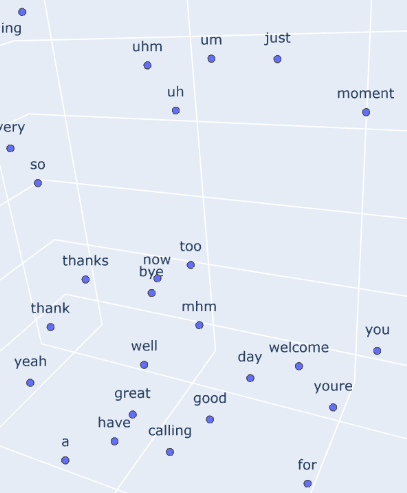

In [19]:
fig = px.scatter_3d(x=x2[:200],y=y2[:200],z=z2[:200],text=list(model_FT.wv.key_to_index)[:200])
fig.update_traces(marker=dict(size=3,line=dict(width=2)),textfont_size=10)
fig.show()

## **Wav2Vec2 for English ASR on the Harper Valley Bank dataset with Transformers**

In this section, we fine tune a wav2vec model for speech-to-text on the Harper Valley Bank dataset.

Wav2Vec2 is a pretrained model for Automatic Speech Recognition (ASR) and was released in [September 2020](https://ai.facebook.com/blog/wav2vec-20-learning-the-structure-of-speech-from-raw-audio/) by Alexei Baevski, Michael Auli, and Alex Conneau.

Using a novel contrastive pretraining objective, Wav2Vec2 learns powerful speech representations from more than 50.000 hours of unlabeled speech. Similar, to [BERT's masked language modeling](http://jalammar.github.io/illustrated-bert/), the model learns contextualized speech representations by randomly masking feature vectors before passing them to a transformer network.

![wav2vec2_structure](https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/wav2vec2.png)

For the first time, it has been shown that pretraining, followed by fine-tuning on very little labeled speech data achieves competitive results to state-of-the-art ASR systems. Using as little as 10 minutes of labeled data, Wav2Vec2 yields a word error rate (WER) of less than 5% on the clean test set of [LibriSpeech](https://huggingface.co/datasets/librispeech_asr) - *cf.* with Table 9 of the [paper](https://arxiv.org/pdf/2006.11477.pdf).

Wav2Vec2 is fine-tuned using Connectionist Temporal Classification (CTC), which is an algorithm that is used to train neural networks for sequence-to-sequence problems and mainly in Automatic Speech Recognition and handwriting recognition.


### Prepare Data, Tokenizer, Feature Extractor

ASR models transcribe speech to text, which means that we both need a feature extractor that processes the speech signal to the model's input format, *e.g.* a feature vector, and a tokenizer that processes the model's output format to text.

In 🤗 Transformers, the Wav2Vec2 model is thus accompanied by both a tokenizer, called [Wav2Vec2CTCTokenizer](https://huggingface.co/transformers/master/model_doc/wav2vec2.html#wav2vec2ctctokenizer), and a feature extractor, called [Wav2Vec2FeatureExtractor](https://huggingface.co/transformers/master/model_doc/wav2vec2.html#wav2vec2featureextractor).

Let's start by creating the tokenizer responsible for decoding the model's predictions.

#### Create Wav2Vec2CTCTokenizer

The [pretrained Wav2Vec2 checkpoint]( ) maps the speech signal to a sequence of context representations as illustrated in the figure above. A fine-tuned Wav2Vec2 checkpoint needs to map this sequence of context representations to its corresponding transcription so that a linear layer has to be added on top of the transformer block (shown in yellow). This linear layer is used to classifies each context representation to a token class analogous how, *e.g.*, after pretraining a linear layer is added on top of BERT's embeddings for further classification - *cf.* with *"BERT"* section of this [blog post](https://huggingface.co/blog/warm-starting-encoder-decoder).

The output size of this layer corresponds to the number of tokens in the vocabulary, which does **not** depend on Wav2Vec2's pretraining task, but only on the labeled dataset used for fine-tuning. So in the first step, we will take a look at Timit and define a vocabulary based on the dataset's transcriptions.

Let's start by loading the dataset and taking a look at its structure. Hugging face already provide the Harper Valley Dataset, formatted in the optimal way for tasks which involves audio

In [ ]:
from datasets import load_dataset, Audio, load_metric

dataset = load_dataset(
    "asapp/slue-phase-2", "hvb"
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning:


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.



Generating train split:   0%|          | 0/11344 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1690 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6121 [00:00<?, ? examples/s]

In [ ]:
dataset #it's divided into train, validation and test


DatasetDict({
    train: Dataset({
        features: ['issue_id', 'audio', 'speaker_id', 'text', 'utt_index', 'channel', 'role', 'start_ms', 'duration_ms', 'intent', 'dialog_acts'],
        num_rows: 11344
    })
    validation: Dataset({
        features: ['issue_id', 'audio', 'speaker_id', 'text', 'utt_index', 'channel', 'role', 'start_ms', 'duration_ms', 'intent', 'dialog_acts'],
        num_rows: 1690
    })
    test: Dataset({
        features: ['issue_id', 'audio', 'speaker_id', 'text', 'utt_index', 'channel', 'role', 'start_ms', 'duration_ms', 'intent', 'dialog_acts'],
        num_rows: 6121
    })
})

We will only consider the transcribed text for fine-tuning.



In [ ]:
dataset = dataset.remove_columns(['issue_id', 'speaker_id', 'utt_index', 'channel', 'role', 'start_ms', 'duration_ms', 'intent', 'dialog_acts'])

Let's write a short function to display some random samples of the dataset and run it a couple of times to get a feeling for the transcriptions.

In [ ]:
from datasets import ClassLabel
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=10):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    display(HTML(df.to_html()))

In [ ]:
show_random_elements(dataset['train'].remove_columns(['audio']), num_examples=10)

,text
0,i would like to transfer money between my accounts
1,john how can i help you today
2,sure i can help you with that uh what day would you like for what day would you like for your appointment
3,hello this is harper valley national bank my name is mary how can i help you today
4,my name is david garcia by the way
5,first street
6,i would you like to set my password
7,hello this is harper valley national bank my name is michael how can i help you today
8,that'll be all thank you
9,thank you for calling have a great day


We can see that the transcriptions contain some special characters, such as `,.?!;:`. Without a language model, it is much harder to classify speech chunks to such special characters because they don't really correspond to a characteristic sound unit. *E.g.*, the letter `"s"` has a more or less clear sound, whereas the special character `"."` does not.
Also in order to understand the meaning of a speech signal, it is usually not necessary to include special characters in the transcription.

In addition, we normalize the text to only have lower case letters and append a word separator token at the end.

In [ ]:
import re
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"]'

def remove_special_characters(batch):
    batch["text"] = re.sub(chars_to_ignore_regex, '', batch["text"]).lower() + " "
    return batch

In [ ]:
dataset = dataset.map(remove_special_characters)

Map:   0%|          | 0/11344 [00:00<?, ? examples/s]

Map:   0%|          | 0/1690 [00:00<?, ? examples/s]

Map:   0%|          | 0/6121 [00:00<?, ? examples/s]

In [ ]:
show_random_elements(dataset["train"].remove_columns(["audio"]))

,text
0,thank you for calling have a great day
1,okay thank you
2,that's everything for today thank you very much
3,what is the company address
4,hello this is harper valley national bank my name is james how can i help you today
5,oh no that's actually all i need for today thank you so much
6,yes five seven four nine four
7,what is the transfer amount is
8,no that'll be all thank you
9,is there anything else i can help you with


Good! This looks better. We have removed most special characters from transcriptions and normalized them to lower-case only.

In CTC, it is common to classify speech chunks into letters, so we will do the same here.
Let's extract all distinct letters of the training and test data and build our vocabulary from this set of letters.

We write a mapping function that concatenates all transcriptions into one long transcription and then transforms the string into a set of chars.
It is important to pass the argument `batched=True` to the `map(...)` function so that the mapping function has access to all transcriptions at once.

In [ ]:
def extract_all_chars(batch):
  all_text = " ".join(batch["text"])
  vocab = list(set(all_text))
  return {"vocab": [vocab], "all_text": [all_text]}

In [ ]:
vocabs = dataset.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=dataset.column_names["train"])

Map:   0%|          | 0/11344 [00:00<?, ? examples/s]

Map:   0%|          | 0/1690 [00:00<?, ? examples/s]

Map:   0%|          | 0/6121 [00:00<?, ? examples/s]

Now, we create the union of all distinct letters in the training dataset and test dataset and convert the resulting list into an enumerated dictionary.

In [ ]:
vocab_list = list(set(vocabs["train"]["vocab"][0]) | set(vocabs["test"]["vocab"][0]))

In [ ]:
vocab_dict = {v: k for k, v in enumerate(vocab_list)}
vocab_dict

{'d': 0,
 'l': 1,
 'a': 2,
 'o': 3,
 'u': 4,
 'm': 5,
 'h': 6,
 'j': 7,
 'g': 8,
 'w': 9,
 'x': 10,
 'z': 11,
 't': 12,
 "'": 13,
 'y': 14,
 's': 15,
 'p': 16,
 'f': 17,
 'v': 18,
 ' ': 19,
 'n': 20,
 'b': 21,
 'k': 22,
 'q': 23,
 'r': 24,
 'i': 25,
 'c': 26,
 'e': 27}

Cool, we see that all letters of the alphabet occur in the dataset (which is not really surprising) and we also extracted the special characters `" "` and `'`. Note that we did not exclude those special characters because:

- The model has to learn to predict when a word finished or else the model prediction would always be a sequence of chars which would make it impossible to separate words from each other.
- In English, we need to keep the `'` character to differentiate between words, *e.g.*, `"it's"` and `"its"` which have very different meanings.

To make it clearer that `" "` has its own token class, we give it a more visible character `|`. In addition, we also add an "unknown" token so that the model can later deal with characters not encountered in Timit's training set.

Finally, we also add a padding token that corresponds to CTC's "*blank token*". The "blank token" is a core component of the CTC algorithm. For more information, please take a look at the "Alignment" section [here](https://distill.pub/2017/ctc/).

In [ ]:
vocab_dict["|"] = vocab_dict[" "]
del vocab_dict[" "]

In [ ]:
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)
len(vocab_dict)

30

Cool, now our vocabulary is complete and consists of 30 tokens, which means that the linear layer that we will add on top of the pretrained Wav2Vec2 checkpoint will have an output dimension of 30.

Let's now save the vocabulary as a json file.

In [ ]:
import json
with open('vocab.json', 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)

In a final step, we use the json file to instantiate an object of the `Wav2Vec2CTCTokenizer` class.

In [ ]:
from transformers import Wav2Vec2CTCTokenizer

tokenizer = Wav2Vec2CTCTokenizer("./vocab.json", unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token="|")

#### Create Wav2Vec2 Feature Extractor

Speech is a continuous signal and to be treated by computers, it first has to be discretized, which is usually called **sampling**. The sampling rate hereby plays an important role in that it defines how many data points of the speech signal are measured per second. Therefore, sampling with a higher sampling rate results in a better approximation of the *real* speech signal but also necessitates more values per second.

A pretrained checkpoint expects its input data to have been sampled more or less from the same distribution as the data it was trained on. The same speech signals sampled at two different rates have a very different distribution, *e.g.*, doubling the sampling rate results in data points being twice as long. Thus,
before fine-tuning a pretrained checkpoint of an ASR model, it is crucial to verify that the sampling rate of the data that was used to pretrain the model matches the sampling rate of the dataset used to fine-tune the model.

Wav2Vec2 was pretrained on the audio data of [LibriSpeech](https://huggingface.co/datasets/librispeech_asr) and LibriVox which both were sampling with 16kHz. **Unfortunately our dataset was sampled with 8kHz. To solve this issue we can either change the striding of the feature extractor so to encode apporximately the same amount of audio OR upsample the audio to 16kHz** with for example torchaudio.


A Wav2Vec2 feature extractor object requires the following parameters to be instantiated:

- `feature_size`: Speech models take a sequence of feature vectors as an input. While the length of this sequence obviously varies, the feature size should not. In the case of Wav2Vec2, the feature size is 1 because the model was trained on the raw speech signal ${}^2$.
- `sampling_rate`: The sampling rate at which the model is trained on.
- `padding_value`: For batched inference, shorter inputs need to be padded with a specific value
- `do_normalize`: Whether the input should be *zero-mean-unit-variance* normalized or not. Usually, speech models perform better when normalizing the input
- `return_attention_mask`: Whether the model should make use of an `attention_mask` for batched inference. In general, models should **always** make use of the `attention_mask` to mask padded tokens. However, due to a very specific design choice of `Wav2Vec2`'s "base" checkpoint, better results are achieved when using no `attention_mask`. This is **not** recommended for other speech models. For more information, one can take a look at [this](https://github.com/pytorch/fairseq/issues/3227) issue. **Important** If you want to use this notebook to fine-tune [large-lv60](https://huggingface.co/facebook/wav2vec2-large-lv60), this parameter should be set to `True`.

In [ ]:
from transformers import Wav2Vec2FeatureExtractor
feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=False)

Great, Wav2Vec2's feature extraction pipeline is thereby fully defined!

To make the usage of Wav2Vec2 as user-friendly as possible, the feature extractor and tokenizer are *wrapped* into a single `Wav2Vec2Processor` class so that one only needs a `model` and `processor` object.

In [ ]:
from transformers import Wav2Vec2Processor

processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

Next, we can prepare the dataset for training.

#### Preprocess Data

So far, we have not looked at the actual values of the speech signal but just the transcription. In addition to `'text'`, our datasets include two more column names `'file'` and `'audio'`. `'file'` states the absolute path of the audio file. Let's take a look.

In [ ]:
dataset['train'][7]['audio']

{'path': '0002f70f7386445b_21539_23369.wav',
 'array': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        -3.05175781e-05, -3.05175781e-05,  0.00000000e+00]),
 'sampling_rate': 16000}

`Wav2Vec2` expects the input in the format of a 1-dimensional array of 16 kHz. This means that the audio file has to be loaded and resampled.

 Thankfully, `datasets` does this automatically when calling the column `audio`. Let try it out.

In [ ]:
dataset["train"][0]["audio"]

{'path': '0002f70f7386445b_1669_4339.wav',
 'array': array([0., 0., 0., ..., 0., 0., 0.]),
 'sampling_rate': 16000}

We can see that the audio file has automatically been loaded. This is thanks to the new [`"Audio"` feature](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=audio#datasets.Audio) introduced in `datasets == 4.13.3`, which loads and resamples audio files on-the-fly upon calling.

The sampling rate is set to 16kHz which is what `Wav2Vec2` expects as an input.

Great, let's listen to a couple of audio files to better understand the dataset and verify that the audio was correctly loaded.

**Note**: *You can click the following cell a couple of times to listen to different speech samples.*

In [ ]:
import IPython.display as ipd
import numpy as np
import random

rand_int = random.randint(0, len(dataset["train"]))

print(dataset["train"][rand_int]["text"])
ipd.Audio(data=np.asarray(dataset["train"][rand_int]["audio"]["array"]), autoplay=True, rate=16000)

hi i'm sorry this this call uh hello this is harper valley national bank my name is dawn how can i help you today 


It can be heard, that the speakers change along with their speaking rate, accent, etc. Overall, the recordings sound relatively clear though, which is to be expected from a read speech corpus.

Let's do a final check that the data is correctly prepared, by printing the shape of the speech input, its transcription, and the corresponding sampling rate.

**Note**: *You can click the following cell a couple of times to verify multiple samples.*

In [ ]:
rand_int = random.randint(0, len(dataset["train"]))

print("Target text:", dataset["train"][rand_int]["text"])
print("Input array shape:", np.asarray(dataset["train"][rand_int]["audio"]["array"]).shape)
print("Sampling rate:", dataset["train"][rand_int]["audio"]["sampling_rate"])

Target text: yes one five 
Input array shape: (20640,)
Sampling rate: 16000


Good! Everything looks fine - the data is a 1-dimensional array, the sampling rate always corresponds to 16kHz, and the target text is normalized.

Finally, we can process the dataset to the format expected by the model for training. We will make use of the `map(...)` function.

First, we load and resample the audio data, simply by calling `batch["audio"]`.
Second, we extract the `input_values` from the loaded audio file. In our case, the `Wav2Vec2Processor` only normalizes the data. For other speech models, however, this step can include more complex feature extraction, such as [Log-Mel feature extraction](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum).
Third, we encode the transcriptions to label ids.

**Note**: This mapping function is a good example of how the `Wav2Vec2Processor` class should be used. In "normal" context, calling `processor(...)` is redirected to `Wav2Vec2FeatureExtractor`'s call method. When wrapping the processor into the `as_target_processor` context, however, the same method is redirected to `Wav2Vec2CTCTokenizer`'s call method.
For more information please check the [docs](https://huggingface.co/transformers/master/model_doc/wav2vec2.html#transformers.Wav2Vec2Processor.__call__).

In [ ]:
def prepare_dataset(batch):
    audio = batch["audio"]

    # batched output is "un-batched" to ensure mapping is correct
    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    batch["input_length"] = len(batch["input_values"])

    with processor.as_target_processor():
        batch["labels"] = processor(batch["text"]).input_ids
    return batch

Let's apply the data preparation function to all examples.

In [ ]:
dataset = dataset.map(prepare_dataset, remove_columns=dataset.column_names["train"], num_proc=4)

Map (num_proc=4):   0%|          | 0/11344 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:156: UserWarning:

`as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.

/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:156: UserWarning:

`as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.

/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:156: UserWarning:

`as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the sam

Map (num_proc=4):   0%|          | 0/1690 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:156: UserWarning:

`as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.

/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:156: UserWarning:

`as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.

/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:156: UserWarning:

`as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the sam

Map (num_proc=4):   0%|          | 0/6121 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:156: UserWarning:

`as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.

/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:156: UserWarning:

`as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.

/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:156: UserWarning:

`as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the sam

Long input sequences require a lot of memory. Since `Wav2Vec2` is based on `self-attention` the memory requirement scales quadratically with the input length for long input sequences (*cf.* with [this](https://www.reddit.com/r/MachineLearning/comments/genjvb/d_why_is_the_maximum_input_sequence_length_of/) reddit post). For this demo, let's filter all sequences that are longer than 5 seconds out of the training dataset.

In [ ]:
max_input_length_in_sec = 5.0
dataset["train"] = dataset["train"].filter(lambda x: x < max_input_length_in_sec * processor.feature_extractor.sampling_rate, input_columns=["input_length"])

Filter:   0%|          | 0/11344 [00:00<?, ? examples/s]

Awesome, now we are ready to start training!

### Training & Evaluation

The data is processed so that we are ready to start setting up the training pipeline. We will make use of 🤗's [Trainer](https://huggingface.co/transformers/master/main_classes/trainer.html?highlight=trainer) for which we essentially need to do the following:

- Define a data collator. In contrast to most NLP models, Wav2Vec2 has a much larger input length than output length. *E.g.*, a sample of input length 50000 has an output length of no more than 100. Given the large input sizes, it is much more efficient to pad the training batches dynamically meaning that all training samples should only be padded to the longest sample in their batch and not the overall longest sample. Therefore, fine-tuning Wav2Vec2 requires a special padding data collator, which we will define below

- Evaluation metric. During training, the model should be evaluated on the word error rate. We should define a `compute_metrics` function accordingly

- Load a pretrained checkpoint. We need to load a pretrained checkpoint and configure it correctly for training.

- Define the training configuration.

After having fine-tuned the model, we will correctly evaluate it on the test data and verify that it has indeed learned to correctly transcribe speech.

#### Set-up Trainer

Let's start by defining the data collator. The code for the data collator was copied from [this example](https://github.com/huggingface/transformers/blob/9a06b6b11bdfc42eea08fa91d0c737d1863c99e3/examples/research_projects/wav2vec2/run_asr.py#L81).

Without going into too many details, in contrast to the common data collators, this data collator treats the `input_values` and `labels` differently and thus applies to separate padding functions on them (again making use of Wav2Vec2's context manager). This is necessary because in speech input and output are of different modalities meaning that they should not be treated by the same padding function.
Analogous to the common data collators, the padding tokens in the labels with `-100` so that those tokens are **not** taken into account when computing the loss.

In [ ]:
import torch

from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        return batch

In [ ]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

Next, the evaluation metric is defined. As mentioned earlier, the
predominant metric in ASR is the word error rate (WER), hence we will use it in this notebook as well.

In [ ]:
wer_metric = load_metric("wer")

<ipython-input-57-605de035dfd7>:1: FutureWarning:

load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate

/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning:

The repository for wer contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/wer/wer.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.



The model will return a sequence of logit vectors:
$\mathbf{y}_1, \ldots, \mathbf{y}_m$ with $\mathbf{y}_1 = f_{\theta}(x_1, \ldots, x_n)[0]$ and $n >> m$.

A logit vector $\mathbf{y}_1$ contains the log-odds for each word in the vocabulary we defined earlier, thus $\text{len}(\mathbf{y}_i) =$ `config.vocab_size`. We are interested in the most likely prediction of the model and thus take the `argmax(...)` of the logits. Also, we transform the encoded labels back to the original string by replacing `-100` with the `pad_token_id` and decoding the ids while making sure that consecutive tokens are **not** grouped to the same token in CTC style ${}^1$.

In [ ]:
def compute_metrics(pred):
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

Now, we can load the pretrained `Wav2Vec2` checkpoint. The tokenizer's `pad_token_id` must be to define the model's `pad_token_id` or in the case of `Wav2Vec2ForCTC` also CTC's *blank token* ${}^2$. To save GPU memory, we enable PyTorch's [gradient checkpointing](https://pytorch.org/docs/stable/checkpoint.html) and also set the loss reduction to "*mean*".

In [ ]:
from transformers import Wav2Vec2ForCTC

model = Wav2Vec2ForCTC.from_pretrained(
     "facebook/wav2vec2-base",
     ctc_loss_reduction="mean",
     pad_token_id=processor.tokenizer.pad_token_id,
 )

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:364: UserWarning:

Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.



pytorch_model.bin:   0%|          | 0.00/380M [00:00<?, ?B/s]

Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base and are newly initialized: ['lm_head.bias', 'lm_head.weight', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


The first component of Wav2Vec2 consists of a stack of CNN layers that are used to extract acoustically meaningful - but contextually independent - features from the raw speech signal. This part of the model has already been sufficiently trained during pretrainind and as stated in the [paper](https://arxiv.org/abs/2006.11477) does not need to be fine-tuned anymore.
Thus, we can set the `requires_grad` to `False` for all parameters of the *feature extraction* part.

In [ ]:
model.freeze_feature_encoder()

In a final step, we define all parameters related to training.
To give more explanation on some of the parameters:
- `group_by_length` makes training more efficient by grouping training samples of similar input length into one batch. This can significantly speed up training time by heavily reducing the overall number of useless padding tokens that are passed through the model
- `learning_rate` and `weight_decay` were heuristically tuned until fine-tuning has become stable. Note that those parameters strongly depend on the our dataset and might be suboptimal for other speech datasets.



In [ ]:
from transformers import TrainingArguments

output_dir = "./ASR_fine_tune_HarperValleyBank"

training_args = TrainingArguments(
  output_dir = output_dir,
  group_by_length=True,
  per_device_train_batch_size=16,
  eval_strategy="steps",
  num_train_epochs=5,
  fp16=True,
  gradient_checkpointing=True,
  save_steps=500,
  eval_steps=500,
  learning_rate=1e-4,
  weight_decay=0.005,
  warmup_steps=1000,
  save_total_limit=5,
  #resume_from_checkpoint = True,

)

Now, all instances can be passed to Trainer and we are ready to start training!

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    tokenizer=processor.feature_extractor,
)



---

${}^1$ To allow models to become independent of the speaker rate, in CTC, consecutive tokens that are identical are simply grouped as a single token. However, the encoded labels should not be grouped when decoding since they don't correspond to the predicted tokens of the model, which is why the `group_tokens=False` parameter has to be passed. If we wouldn't pass this parameter a word like `"hello"` would incorrectly be encoded, and decoded as `"helo"`.

${}^2$ The blank token allows the model to predict a word, such as `"hello"` by forcing it to insert the blank token between the two l's. A CTC-conform prediction of `"hello"` of our model would be `[PAD] [PAD] "h" "e" "e" "l" "l" [PAD] "l" "o" "o" [PAD]`.

#### Training and Saving

In [ ]:
trainer.train( )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommend

Step,Training Loss,Validation Loss,Wer
500,3.794800,3.955482,1.000437
1000,1.401600,0.848130,0.450034
1500,0.674700,0.593325,0.327248
2000,0.521900,0.465086,0.273833
2500,0.402400,0.342672,0.233962
3000,0.333700,0.330701,0.226742


/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/wav2vec2/processing_wav2vec2.py:155: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Tran

TrainOutput(global_step=3065, training_loss=1.1702048328144514, metrics={'train_runtime': 1858.1014, 'train_samples_per_second': 26.368, 'train_steps_per_second': 1.65, 'total_flos': 7.647013743140966e+17, 'train_loss': 1.1702048328144514, 'epoch': 5.0})

The final WER should be around 0.3 which is reasonable given that state-of-the-art phoneme error rates (PER) are just below 0.1 (see [leaderboard](https://paperswithcode.com/sota/speech-recognition-on-timit)) and that WER is usually worse than PER.

Let's save the model for later use

In [ ]:
model.save_pretrained(output_dir)
processor.save_pretrained(output_dir)

#### Evaluate

In the final part, we run our model on some of the validation data to get a feeling for how well it works.

Let's load the `processor` and `model`.

Now, we will make use of the `map(...)` function to predict the transcription of every test sample and to save the prediction in the dataset itself. We will call the resulting dictionary `"results"`.

**Note**: we evaluate the test data set with `batch_size=1` on purpose due to this [issue](https://github.com/pytorch/fairseq/issues/3227). Since padded inputs don't yield the exact same output as non-padded inputs, a better WER can be achieved by not padding the input at all.

In [ ]:
from transformers import AutoProcessor, Wav2Vec2ForCTC

processor = AutoProcessor.from_pretrained(output_dir)
model = Wav2Vec2ForCTC.from_pretrained(output_dir).cuda()

In [ ]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    do_train=False,
    do_eval=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    tokenizer=processor,
)



In [ ]:
predictions = trainer.predict(dataset["validation"])

In [ ]:
pred_str = processor.batch_decode(torch.argmax(torch.from_numpy(predictions.predictions), dim=-1))
ref_str = processor.batch_decode(predictions.label_ids)
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=pred_str, references=ref_str)))

Test WER: 1.000


In [ ]:
def map_to_result(batch):
  with torch.no_grad():
    input_values = torch.tensor(batch["input_values"], device="cuda").unsqueeze(0)
    logits = model(input_values).logits

  pred_ids = torch.argmax(logits, dim=-1)
  batch["pred_str"] = processor.batch_decode(pred_ids)[0]
  batch["text"] = processor.decode(batch["labels"], group_tokens=False)

  return batch

In [ ]:
results = dataset["test"].map(map_to_result, remove_columns=dataset["test"].column_names)

Parameter 'function'=<function map_to_result at 0x7f7019ee5990> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/6121 [00:00<?, ? examples/s]

Let's compute the overall WER now.

In [ ]:
print("Test WER: {:.3f}".format(wer_metric.compute(predictions=results["pred_str"], references=results["text"])))

Test WER: 0.080


Let's take a look at some predictions to see what errors are made by the model.

In [ ]:
show_random_elements(results)

,pred_str,text
0,bye bye e,bye bye
1,what is the transfer amount,what is the transfer amount
2,a new checkbook has been sent to your home address,a new check book has been sent to your home address
3,hello this is harper valley national bank,hello this is harper valley national bank
4,okay your appointment has been scheduled for monday at eight forty five a mis there anything else i can help you with,okay your appointment has been scheduled for monday at eight forty five a m is there anything else i can help you with
5,um,um
6,a new checkbook has been sen to your home address it suld arive within thre to five ds ags man,a new checkbook has been sent to your home address it should arrive within three to five business days ma'am
7,hi my name is linda rodriguez i'd like to check my account balance,hi my name is linda rodriguez i'd like to check my account balance
8,hi my name is jamesjnes,hi my name is james dunes
9,how can i help you today,how can i help you today


It becomes clear that the predicted transcriptions are acoustically very similar to the target transcriptions, but often contain spelling or grammatical errors. This shouldn't be very surprising though given that we purely rely on Wav2Vec2 without making use of a language model.

Finally, to better understand how CTC works, it is worth taking a deeper look at the exact output of the model. Let's run the first test sample through the model, take the predicted ids and convert them to their corresponding tokens.

In [ ]:
model.to("cuda")

with torch.no_grad():
  logits = model(torch.tensor(dataset["validation"][:1]["input_values"], device="cuda")).logits

pred_ids = torch.argmax(logits, dim=-1)

# convert ids to tokens
" ".join(processor.tokenizer.convert_ids_to_tokens(pred_ids[0].tolist()))

'[PAD] [PAD] h h e e l l [PAD] [PAD] l l l l l l o o o | | | | t t h i i s s | [PAD] [PAD] i s s | | [PAD] [PAD] [PAD] h h h a a a r r p [PAD] [PAD] [PAD] e e r r r r | | [PAD] [PAD] [PAD] v [PAD] [PAD] a a l l [PAD] [PAD] l e e e y | | [PAD] n [PAD] [PAD] a a t t t i i o o n n n a a l l l | [PAD] [PAD] b [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] a a n n k k [PAD] | [PAD] [PAD] [PAD] [PAD] [PAD] m m y y | | n n a a m e e | i i s s | | [PAD] [PAD] [PAD] [PAD] [PAD] r r r [PAD] [PAD] o o o [PAD] [PAD] [PAD] [PAD] f e e e r r r r t t [PAD] | [PAD] [PAD] [PAD] h h o o w | | [PAD] c a a n n | | [PAD] i i | | | [PAD] [PAD] h h e e e l l p p | [PAD] y y o o u | | [PAD] [PAD] t t o o o d d d [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] a a y y [PAD] [PAD] |'

The output should make it a bit clearer how CTC works in practice. The model is to some extent invariant to speaking rate since it has learned to either just repeat the same token in case the speech chunk to be classified still corresponds to the same token. This makes CTC a very powerful algorithm for speech recognition since the speech file's transcription is often very much independent of its length.


## **Chatbot for the Harper Valley Bank Dataset**

In this section, we fine tune a pre-trained transformer model to the Harper Valley Dataset to obtain a chatbot

### Initial imports

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import re
import json
import torch
import datasets
from sklearn.model_selection import train_test_split

In [ ]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
from tqdm.notebook import tqdm, trange

from transformers import (
    AdamW,
    AutoConfig,
    AutoModelWithLMHead,
    AutoTokenizer,
    PreTrainedModel,
    PreTrainedTokenizer,
    get_linear_schedule_with_warmup,
)

### Load the data and get conversations

Get the data

In [ ]:
import pandas as pd
transcript_data = pd.read_csv('TranscriptDB.csv')

Clean the data by removing noise and unknown symbols from the human transcription

In [ ]:
transcript_data_sorted = transcript_data.sort_values(by=['index'])

# The unique words included in the conversations which don't have a specific meaning, for example [noise] [cough] ecc
unique_words = set(word for sublist in transcript_data_sorted['human_transcript'].str.findall(r'\[([^\]]+)\]').dropna() for word in sublist)

print(unique_words)

pattern = r'(\[(' + '|'.join(unique_words) + r')\])|\<unk\>'

# Substitute the unique words and the <unk> symbols in each conversation with the empty '' string
transcript_data_sorted['human_transcript'] = transcript_data_sorted['human_transcript'].replace(to_replace=pattern, value='', regex=True).str.strip()

# Remove frome the dataframe the rows for wich the human_transcript is empty
transcript_data_sorted.drop(transcript_data_sorted[transcript_data_sorted['human_transcript'] == ''].index, inplace=True)
transcript_data_sorted = transcript_data_sorted.dropna(subset=['human_transcript'])


{'unintelligible', 'baby', 'music', 'kids', 'noise', 'ringing', 'dogs', 'laughter', 'cough'}


Get the list of conversations

In [ ]:
# Function to convert DataFrame to array of arrays of dictionaries
def convert_to_conversations(df):
    conversations = []

    # Group by 'identifier'
    grouped = df.groupby('identifier')

    for group_id, group_df in grouped:
        # Sort by 'index'
        sorted_group = group_df.sort_values(by='index')

        # Initialize the list for this conversation
        conversation = []

        # Iterate through the sorted rows
        previous_type = None
        accumulated_text = ""

        for _, row in sorted_group.iterrows():
            current_type = row['speaker_role']
            current_text = row['human_transcript']

            if current_type == previous_type:
                # Concatenate text if the type is the same as the previous one
                accumulated_text += " " + current_text
            else:
                # Add the previous accumulated text to the conversation list
                if previous_type is not None:
                    conversation.append({'speaker_role': previous_type, 'text': accumulated_text})

                # Reset for the new type
                previous_type = current_type
                accumulated_text = current_text

        # Add the last accumulated text to the conversation list
        if previous_type is not None:
            conversation.append({'speaker_role': previous_type, 'text': accumulated_text})

        # Add to the final list of conversations
        conversations.append(conversation)

    return conversations

# Get the conversations
conversations = convert_to_conversations(transcript_data_sorted)
print(conversations[0])

[{'speaker_role': 'agent', 'text': 'hello this is harper valley national bank my name is elizabeth how can i help you today'}, {'speaker_role': 'caller', 'text': 'hi my name is patricia brown i lost my debit card can you send me a new one'}, {'speaker_role': 'agent', 'text': 'which card would you like to replace'}, {'speaker_role': 'caller', 'text': 'my debit card'}, {'speaker_role': 'agent', 'text': 'can you repeat that please'}, {'speaker_role': 'caller', 'text': 'yes my debit card'}, {'speaker_role': 'agent', 'text': 'is there anything else i can help you with today'}, {'speaker_role': 'caller', 'text': 'no that was going to be it'}, {'speaker_role': 'agent', 'text': 'thank you for calling have a great day'}, {'speaker_role': 'caller', 'text': 'bye'}]


Split the data in training and validation

In [ ]:
train_data, validation_data = train_test_split(conversations,test_size=0.2)

### Load the model and preprocessing

We load the model to fine tune

In [ ]:
output_dir = 'chatbot-3'
model_name_or_path = 'microsoft/DialoGPT-medium'

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
config = AutoConfig.from_pretrained(model_name_or_path)
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path)
model = AutoModelWithLMHead.from_pretrained(
    model_name_or_path,
    from_tf=False,
    config=config,
)
model.to(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning:

`resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.



config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/auto/modeling_auto.py:1712: FutureWarning:

The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.



pytorch_model.bin:   0%|          | 0.00/863M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=50257, bias=False)
)

We set the pad_token to the eos_token

In [ ]:
tokenizer.pad_token = tokenizer.eos_token

We convert each conversation in a dialogue string

In [ ]:
def sample_to_string(sample, eos_token):
    # Join strings
    dialogue = eos_token.join(f" {utterance['speaker_role']}: {utterance['text']} " for utterance in sample)
    # Build the dialogue string
    dialogue_string = f"{dialogue}{eos_token}"

    return dialogue_string

We apply the function to all the conversations

In [ ]:
train_data_str = [sample_to_string(dialogue, tokenizer.eos_token) for dialogue in train_data]
validation_data_str = [sample_to_string(dialogue, tokenizer.eos_token) for dialogue in validation_data]

In [ ]:
validation_data_str[0]

" agent: hello this is harper valley national bank my name is patricia how can i help you today <|endoftext|> caller: uh my name is elizabeth garcia and i want to ask what are the local branch hours <|endoftext|> agent: okay um could you repeat that for me real quick <|endoftext|> caller: i just want to know what are the local branch hours <|endoftext|> agent: okay all our branch hours are from nine thirty am to five p m is there anything else i can help you with today <|endoftext|> caller: nope that's all i needed thank you <|endoftext|> agent: okay thank you for calling have a great day <|endoftext|> caller: you too <|endoftext|>"

Define the Dataset class

In [ ]:
class ConversationDataset(Dataset):
    def __init__(self, tokenizer, conversations):

        self.examples = []
        for c in conversations:
            conv = tokenizer.encode(c, max_length = 500, padding = 'max_length')
            self.examples.append(conv)


    def __len__(self):
        return len(self.examples)

    def __getitem__(self, item):
        return torch.tensor(self.examples[item], dtype=torch.long)

Define the function for loading a specific split of the data

In [ ]:
def load_and_cache_examples(tokenizer, df_trn, df_val, evaluate=False):
    return ConversationDataset(tokenizer, df_val if evaluate else df_trn)

### Training

Define the training loop. It's a standard Pytorch training loop

In [ ]:
# Training of model

def train(train_dataset, model: PreTrainedModel, tokenizer: PreTrainedTokenizer):
    """ Train the model """

    #Training Arguments
    train_batch_size = 1
    num_train_epochs = 3
    gradient_accumulation_steps = 8
    warmup_steps = 0
    learning_rate = 5e-5
    adam_epsilon = 1e-8
    weight_decay = 0.0
    save_steps = 500
    overwrite_output_dir = True

    #Collate
    def collate(examples):
        if tokenizer._pad_token is None:
            return pad_sequence(examples, batch_first=True)
        return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)


    #Data Loader
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(
        train_dataset, sampler=train_sampler, batch_size=train_batch_size, collate_fn=collate, drop_last = True
    )

    t_total = len(train_dataloader) // gradient_accumulation_steps * num_train_epochs

    model.resize_token_embeddings(len(tokenizer))

    # Prepare optimizer(AdamW) and scheduler (linear warmup and decay)
    no_decay = ["bias", "LayerNorm.weight"]
    optimizer_grouped_parameters = [
        {
            "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
            "weight_decay": weight_decay,
        },
        {"params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], "weight_decay": 0.0},
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=warmup_steps, num_training_steps=t_total
    )


    # TRAIN
    global_step = 0
    epochs_trained = 0
    steps_trained_in_current_epoch = 0

    # Check if continuing training from a checkpoint
    if model_name_or_path and os.path.exists(model_name_or_path):
        try:
            # set global_step to gobal_step of last saved checkpoint from model path
            checkpoint_suffix = model_name_or_path.split("-")[-1].split("/")[0]
            global_step = int(checkpoint_suffix)
            epochs_trained = global_step // (len(train_dataloader) // gradient_accumulation_steps)
            steps_trained_in_current_epoch = global_step % (len(train_dataloader) // gradient_accumulation_steps)
        except ValueError:
            print("  Starting fine-tuning.")

    tr_loss = 0.0

    model.zero_grad()
    train_iterator = trange(
        epochs_trained, int(num_train_epochs), desc="Epoch")

    #Training Loop
    for _ in train_iterator:
        epoch_iterator = tqdm(train_dataloader, desc="Iteration")
        for step, batch in enumerate(epoch_iterator):

            # Skip past any already trained steps if resuming training
            if steps_trained_in_current_epoch > 0:
                steps_trained_in_current_epoch -= 1
                continue

            inputs, labels = (batch, batch)
            if inputs.shape[1] > 1024: continue
            inputs = inputs.to(device)
            labels = labels.to(device)
            model.train()
            outputs = model(inputs, labels=labels)
            loss = outputs[0]  # model outputs are always tuple in transformers

            if gradient_accumulation_steps > 1:
                loss = loss / gradient_accumulation_steps
            loss.backward()

            tr_loss += loss.item()

            if (step + 1) % gradient_accumulation_steps == 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                scheduler.step()  # Update learning rate schedule
                model.zero_grad()
                global_step += 1

                if save_steps > 0 and global_step % save_steps == 0:
                    checkpoint_prefix = "checkpoint"
                    # Save model checkpoint
                    output_dir = os.path.join(output_dir, "{}-{}".format(checkpoint_prefix, global_step))
                    os.makedirs(output_dir, exist_ok=True)
                    model.save_pretrained(output_dir)
                    tokenizer.save_pretrained(output_dir)

                    torch.save(optimizer.state_dict(), os.path.join(output_dir, "optimizer.pt"))
                    torch.save(scheduler.state_dict(), os.path.join(output_dir, "scheduler.pt"))


    return global_step, tr_loss / global_step

Get the training data and start the training process

In [ ]:
# Training
train_dataset = load_and_cache_examples(tokenizer, train_data_str, validation_data_str, evaluate=False)

global_step, tr_loss = train(train_dataset, model, tokenizer)
print(f"global_step = {global_step}, average loss = {tr_loss}")

# Create output directory if needed
os.makedirs(output_dir, exist_ok=True)

model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1156 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1156 [00:00<?, ?it/s]

Iteration:   0%|          | 0/1156 [00:00<?, ?it/s]

global_step = 432, average loss = 0.2189286477293569


/usr/local/lib/python3.10/dist-packages/transformers/models/auto/modeling_auto.py:1699: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=50257, bias=False)
)

### Evaluate the model

Define the evaluation loop

In [ ]:
def evaluate(evaluation_dataset, model: PreTrainedModel, tokenizer: PreTrainedTokenizer, prefix=""):

    eval_batch_size = 1

    def collate(examples):
        if tokenizer._pad_token is None:
            return pad_sequence(examples, batch_first=True)
        return pad_sequence(examples, batch_first=True, padding_value=tokenizer.pad_token_id)

    eval_sampler = SequentialSampler(evaluation_dataset)
    eval_dataloader = DataLoader(
        evaluation_dataset, sampler=eval_sampler, batch_size=eval_batch_size, collate_fn=collate, drop_last = True
    )


    # Eval!
    eval_loss = 0.0
    nb_eval_steps = 0
    model.eval()

    for batch in tqdm(eval_dataloader, desc="Evaluating"):
        inputs, labels = (batch, batch)
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            outputs = model(inputs, labels=labels)
            lm_loss = outputs[0]
            eval_loss += lm_loss.mean().item()
        nb_eval_steps += 1

    eval_loss = eval_loss / nb_eval_steps
    perplexity = torch.exp(torch.tensor(eval_loss))

    result = {"perplexity": perplexity}

    return result

Load the model

In [ ]:
# Load a trained model and vocabulary that you have fine-tuned
model = AutoModelWithLMHead.from_pretrained(output_dir)
tokenizer = AutoTokenizer.from_pretrained(output_dir)
model.to(device)


GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(1024, 1024)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1024, out_features=50257, bias=False)
)

Run the evaluation process on the validation dataset

In [ ]:
# Evaluation
evaluation_dataset = load_and_cache_examples(tokenizer, train_data_str, validation_data_str, evaluate=True)

result = evaluate(evaluation_dataset, model, tokenizer)
print(f"Perplexity on the validation set = {result['perplexity']}")

Evaluating:   0%|          | 0/290 [00:00<?, ?it/s]

Perplexity on the validation set = 1.1804152727127075


We can also compute the perplexity on a single example

In [ ]:
import random

random.seed(2)

idx = random.choice(range(len(validation_data)))
dialogue = validation_data[idx]
print(dialogue)

[{'speaker_role': 'agent', 'text': 'hello this is harper valley national bank my name is robert how can i help you today'}, {'speaker_role': 'caller', 'text': 'hi my name is linda smith i need to check my account balance'}, {'speaker_role': 'agent', 'text': "sure i'd be happy to do that for you and what's your name please oh right it's linda smith sorry about that linda smith right and"}, {'speaker_role': 'caller', 'text': 'linda smith all is well'}, {'speaker_role': 'agent', 'text': "alright i'm in and which account would you like to check your savings account or your checking account"}, {'speaker_role': 'caller', 'text': "i'd like to check my checking account please"}, {'speaker_role': 'agent', 'text': 'your checking account balance is ninety dollars exactly'}, {'speaker_role': 'caller', 'text': "fantastic that's all i needed"}, {'speaker_role': 'agent', 'text': 'great is there anything else i could help you with today'}, {'speaker_role': 'caller', 'text': "nope that'll be everything

We obtain the true response

In [ ]:
response_idx = len(dialogue) // 2

original_response = dialogue[response_idx]
original_response_string = f"{original_response['speaker_role']}: {original_response['text']}"
print(original_response_string)

agent: your checking account balance is ninety dollars exactly


We build the context from the dialogue excluding the part starting from the response

In [ ]:
context =dialogue[:response_idx]
context_string = sample_to_string(context, tokenizer.eos_token)
print(context_string.replace(tokenizer.eos_token, '\n'))

 agent: hello this is harper valley national bank my name is robert how can i help you today 
 caller: hi my name is linda smith i need to check my account balance 
 agent: sure i'd be happy to do that for you and what's your name please oh right it's linda smith sorry about that linda smith right and 
 caller: linda smith all is well 
 agent: alright i'm in and which account would you like to check your savings account or your checking account 
 caller: i'd like to check my checking account please 



We generate the response using the model and we observe that the answer seems pretty accurate

In [ ]:
# Encode context
input_encoding = tokenizer(context_string, return_tensors='pt').to(device)
# Generate response
output_ids =  model.generate(input_encoding.input_ids, max_new_tokens=50,num_beams=8, pad_token_id=tokenizer.eos_token_id)
# Decode generated response
generated_response = tokenizer.decode(output_ids[0, input_encoding.input_ids.size(1):], skip_special_tokens=True)
print(generated_response)

 agent: okay your checking account balance is ninety dollars is there anything else i can help you with 


We compute the perplexity

In [ ]:
# Encode dialogue
input_encoding = tokenizer(context_string + original_response_string + tokenizer.eos_token, return_tensors='pt').to(device)
# Compute model outputs
outputs = model(**input_encoding)

In [ ]:
labels = tokenizer(original_response_string + tokenizer.eos_token, return_tensors='pt').input_ids.to(device)
labels.size()

torch.Size([1, 11])

In [ ]:
logits = outputs.logits[:, -labels.size(1):]
logits.size()

torch.Size([1, 11, 50257])

In [ ]:
import torch.nn.functional as F

# Shift logits to exclude the last element
shift_logits = logits[..., :-1, :].contiguous()
# shift labels to exclude the first element
shift_labels = labels[..., 1:].contiguous()
# Compute loss
lm_loss = F.cross_entropy(
    shift_logits.view(-1, shift_logits.size(-1)), shift_labels.view(-1)
)
lm_loss

tensor(2.1973, device='cuda:0', grad_fn=<NllLossBackward0>)

In [ ]:
ppl = torch.exp(lm_loss)
print(ppl)

tensor(9.0010, device='cuda:0', grad_fn=<ExpBackward0>)


### Chatbot interaction

In [ ]:
dialogue = [{'speaker_role': 'agent', 'text': 'hello this is harper valley national bank my name is elizabeth how can i help you today'}]

tokenizer.padding_side = 'left'
# Maximum dialogue length (in turn pairs)
max_len = 10

print(dialogue[0]['text'])

for i in range(max_len):
    # Read user message
    user_message = input("Caller: ")
    # Append message to dialogue history
    dialogue.append(
        {'speaker_role': 'caller', 'text': user_message.lower()}
    )
    # Convert dialogue to string
    input_string = sample_to_string(dialogue, tokenizer.eos_token)
    # Encode input
    input_encoding = tokenizer(input_string, return_tensors='pt').to(device)
    # Generate DialoGPT response
    output_ids = model.generate(input_encoding.input_ids, num_beams=8, max_new_tokens=35, pad_token_id=tokenizer.eos_token_id, early_stopping = True)
    chatbot_response = tokenizer.decode(output_ids[0, input_encoding.input_ids.size(1):], skip_special_tokens=True)
    # Crop initial speaker token
    chatbot_response = chatbot_response[7:]
    # Append chatbot response to dialogue history
    dialogue.append(
        {'speaker_role': 'agent', 'text': chatbot_response}
    )
    # Print chatbot response
    print(f"Chatbot: {chatbot_response}")

## **Text-to-speech by fine-tuning SpeechT5 on the Harper Valley Bank dataset**

In this section, we fine-tune the SpeechT5 model from Hugging Face Transformers on the Harper Valley Bank dataset.


### Load the model

We'll start from SpeechT5 that's already been fine-tuned for English TTS, and fine-tune it again on the Harper Valley Bank dataset.

In [ ]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech

#The processor contains the tokenizer and the feature extractor
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")


preprocessor_config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/232 [00:00<?, ?B/s]

spm_char.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/585M [00:00<?, ?B/s]

### Load the dataset

We load the dataset from HuggingFace. The dataset is a subset of the original dataset and the audio are divided in each utterance, which will make the prediction more effective

In [ ]:
from datasets import load_dataset, Audio

train_dataset = load_dataset(
    "asapp/slue-phase-2", "hvb", split="train"
)
validation_dataset = load_dataset(
    "asapp/slue-phase-2", "hvb", split="validation"
)
test_dataset = load_dataset(
    "asapp/slue-phase-2", "hvb", split="test"
)

It's important to set the sampling rate of the audio data to 16 kHz, which is what SpeechT5 expects.

In [ ]:
train_dataset = train_dataset.cast_column("audio", Audio(sampling_rate=16000))
validation_dataset = validation_dataset.cast_column("audio", Audio(sampling_rate=16000))
test_dataset = test_dataset.cast_column("audio", Audio(sampling_rate=16000))

Let's quickly check how many examples are in each split.

In [ ]:
len(train_dataset), len(validation_dataset), len(test_dataset)

(11344, 1690, 6121)

Let's build a container of all the splits

In [ ]:
from datasets import Dataset, DatasetDict
dataset = DatasetDict()
dataset['train'] = train_dataset
dataset['validation'] = validation_dataset
dataset['test'] = test_dataset

Looking at some examples



In [ ]:
for i in range(10):
  print(dataset['train'][i])

{'issue_id': '0002f70f7386445b', 'audio': {'path': '0002f70f7386445b_1669_4339.wav', 'array': array([0., 0., 0., ..., 0., 0., 0.]), 'sampling_rate': 16000}, 'speaker_id': '46', 'text': 'hello this is harper valley national bank', 'utt_index': 1, 'channel': 2, 'role': 'agent', 'start_ms': 1669, 'duration_ms': 2670, 'intent': 'replace card', 'dialog_acts': ['statement_open']}
{'issue_id': '0002f70f7386445b', 'audio': {'path': '0002f70f7386445b_4839_5979.wav', 'array': array([ 4.76074219e-03,  4.63867188e-03,  2.38037109e-03, ...,
       -3.05175781e-05, -3.05175781e-05,  0.00000000e+00]), 'sampling_rate': 16000}, 'speaker_id': '46', 'text': 'my name is elizabeth', 'utt_index': 2, 'channel': 2, 'role': 'agent', 'start_ms': 4839, 'duration_ms': 1140, 'intent': 'replace card', 'dialog_acts': ['statement_open']}
{'issue_id': '0002f70f7386445b', 'audio': {'path': '0002f70f7386445b_6469_7699.wav', 'array': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
       -3.05175781e-05,  

### Speakers

We compute how many speakers are present in the training dataset and the number of examples for each of them

In [ ]:
from collections import defaultdict
speaker_counts = defaultdict(int)

for speaker_id in dataset["train"]["speaker_id"]:
    speaker_counts[speaker_id] += 1

By plotting a histogram we can get a sense of how much data there is for each speaker.

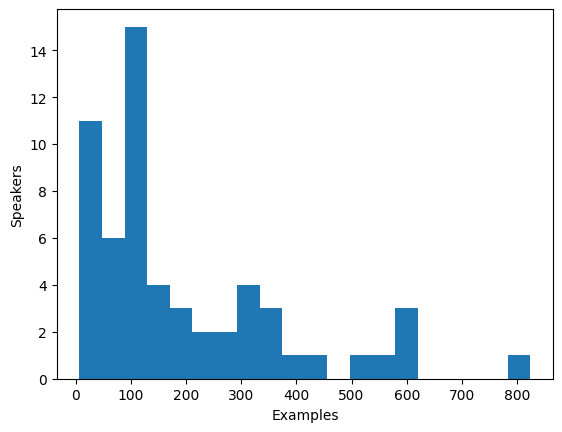

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(speaker_counts.values(), bins=20)
plt.ylabel("Speakers")
plt.xlabel("Examples")
plt.show()

### Speaker embeddings

To allow the TTS model to distinguish between multiple speakers, we create a speaker embedding for each example. The speaker embedding is simply an additional input into the model that captures a particular speaker's voice characteristics.

To create the speaker embeddings, we use the [spkrec-xvect-voxceleb](https://huggingface.co/speechbrain/spkrec-xvect-voxceleb) model from SpeechBrain. The following defines a function `create_speaker_embedding()` that takes an input audio waveform and outputs a 512-element vector containing the corresponding speaker embedding.

In [ ]:
import torch
from speechbrain.inference.classifiers import EncoderClassifier

spk_model_name = "speechbrain/spkrec-xvect-voxceleb"

device = "cuda" if torch.cuda.is_available() else "cpu"
speaker_model = EncoderClassifier.from_hparams(
    source=spk_model_name,
    run_opts={"device": device},
    savedir=os.path.join("/tmp", spk_model_name)
)

def create_speaker_embedding(waveform):
    with torch.no_grad():
        speaker_embeddings = speaker_model.encode_batch(torch.tensor(waveform))
        speaker_embeddings = torch.nn.functional.normalize(speaker_embeddings, dim=2)
        speaker_embeddings = speaker_embeddings.squeeze().cpu().numpy()
    return speaker_embeddings

hyperparams.yaml:   0%|          | 0.00/2.04k [00:00<?, ?B/s]

embedding_model.ckpt:   0%|          | 0.00/16.9M [00:00<?, ?B/s]

mean_var_norm_emb.ckpt:   0%|          | 0.00/3.20k [00:00<?, ?B/s]

classifier.ckpt:   0%|          | 0.00/15.9M [00:00<?, ?B/s]

label_encoder.txt:   0%|          | 0.00/129k [00:00<?, ?B/s]

### Preparing the dataset

The `prepare_dataset` function takes in a single example and uses the `SpeechT5Processor` object to tokenize the input text and load the target audio into a log-mel spectrogram. It also adds the speaker embeddings as an additional input.

In [ ]:
def prepare_dataset(example):
    # load the audio data; if necessary, this resamples the audio to 16kHz
    audio = example["audio"]

    # feature extraction and tokenization
    example = processor(
        text=example["text"],
        audio_target=audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_attention_mask=False,
    )

    # strip off the batch dimension
    example["labels"] = example["labels"][0]

    # use SpeechBrain to obtain x-vector
    example["speaker_embeddings"] = create_speaker_embedding(audio["array"])

    return example

Let's verify the processing is correct by looking at a single example:

In [ ]:
processed_example = prepare_dataset(dataset["train"][0])

This returns:

- the tokens for the input text in `input_ids`
- the speaker embedding in `speaker_embeddings`
- the target spectrogram in `labels`

In [ ]:
list(processed_example.keys())

['input_ids', 'labels', 'speaker_embeddings']

The tokens should decode into the original text, with `</s>` to mark the end of the sentence.

In [ ]:
tokenizer = processor.tokenizer
tokenizer.decode(processed_example["input_ids"])

'hello this is harper valley national bank</s>'

Speaker embeddings should be a 512-element vector:

In [ ]:
processed_example["speaker_embeddings"].shape

(512,)

The labels are a log-mel spectrogram with 80 mel bins.

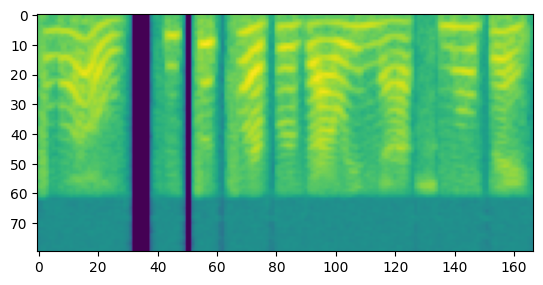

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(processed_example["labels"].T)
plt.show()

If we run a vocoder on the log-mel spectrogram, it should produce the original audio again. We'll load the HiFi-GAN vocoder from the original [SpeechT5 checkpoint](https://hf.co/microsoft/speecht5_hifigan).

In [ ]:
from transformers import SpeechT5HifiGan
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")

config.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/50.7M [00:00<?, ?B/s]

In [ ]:
spectrogram = torch.tensor(processed_example["labels"])
with torch.no_grad():
    speech = vocoder(spectrogram)

In [ ]:
from IPython.display import Audio
Audio(speech.cpu().numpy(), rate=16000)

We can now process the entire dataset

In [ ]:
dataset["train"] = dataset["train"].map(
    prepare_dataset, remove_columns=dataset["train"].column_names,
)
dataset["validation"] = dataset["validation"].map(
    prepare_dataset, remove_columns=dataset["validation"].column_names,
)
dataset["test"] = dataset["test"].map(
    prepare_dataset, remove_columns=dataset["test"].column_names,
)

Map:   0%|          | 0/11344 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:306: UserWarning:

Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)



Map:   0%|          | 0/1690 [00:00<?, ? examples/s]

Map:   0%|          | 0/6121 [00:00<?, ? examples/s]

If some of the examples in the dataset are longer than the maximum input length the model can handle (600 tokens), we remove those from the dataset. In fact, to allow for larger batch sizes we remove anything over 200 tokens.

In [ ]:
def is_not_too_long(input_ids):
    input_length = len(input_ids)
    return input_length < 200

dataset = dataset.filter(is_not_too_long, input_columns=["input_ids"])

Filter:   0%|          | 0/11344 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1690 [00:00<?, ? examples/s]

Filter:   0%|          | 0/6121 [00:00<?, ? examples/s]

### Collator to make batches

We need to define a custom collator to combine multiple examples into a batch. This will pad shorter sequences with padding tokens. For the spectrogram labels, the padded portions are replaced with the special value -100. This special value tells the model to ignore that part of the spectrogram when calculating the spectrogram loss.


In [ ]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class TTSDataCollatorWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:

        input_ids = [{"input_ids": feature["input_ids"]} for feature in features]
        label_features = [{"input_values": feature["labels"]} for feature in features]
        speaker_features = [feature["speaker_embeddings"] for feature in features]

        # collate the inputs and targets into a batch
        batch = processor.pad(
            input_ids=input_ids,
            labels=label_features,
            return_tensors="pt",
        )

        # replace padding with -100 to ignore loss correctly
        batch["labels"] = batch["labels"].masked_fill(
            batch.decoder_attention_mask.unsqueeze(-1).ne(1), -100
        )

        # not used during fine-tuning
        del batch["decoder_attention_mask"]

        # round down target lengths to multiple of reduction factor
        if model.config.reduction_factor > 1:
            target_lengths = torch.tensor([
                len(feature["input_values"]) for feature in label_features
            ])
            target_lengths = target_lengths.new([
                length - length % model.config.reduction_factor for length in target_lengths
            ])
            max_length = max(target_lengths)
            batch["labels"] = batch["labels"][:, :max_length]

        # also add in the speaker embeddings
        batch["speaker_embeddings"] = torch.tensor(speaker_features)

        return batch

In SpeechT5, the input to the decoder part of the model is reduced by a factor 2. In other words, it throws away every other timestep from the target sequence. The decoder then predicts a sequence that is twice as long. Since the original target sequence length may be odd, the data collator makes sure to round the maximum length of the batch down to be a multiple of 2.

In [ ]:
data_collator = TTSDataCollatorWithPadding(processor=processor)

Let's test the data collator.

In [ ]:
features = [
    dataset["train"][0],
    dataset["train"][1],
    dataset["train"][20],
]

batch = data_collator(features)

In [ ]:
{k:v.shape for k,v in batch.items()}

{'input_ids': torch.Size([3, 43]),
 'attention_mask': torch.Size([3, 43]),
 'labels': torch.Size([3, 166, 80]),
 'speaker_embeddings': torch.Size([3, 512])}

Looks good!

### Training

Define the training arguments.

We won't be computing any evaluation metrics during the training process. Instead, we'll only look at the loss. The lower the loss, the better the model.

Note: If you do not want to upload the model checkpoints to the Hub, set `push_to_hub=False`.

In [ ]:
from transformers import Seq2SeqTrainingArguments

output_dir = "./text-to-speech_fine_tune_HarperValleyBank"

training_args = Seq2SeqTrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    learning_rate=1e-5,
    warmup_steps=500,
    max_steps=4000,
    eval_strategy="steps",
    per_device_eval_batch_size=8,
    save_steps=1000,
    eval_steps=1000,
    load_best_model_at_end=True,
    greater_is_better=False,
    label_names=["labels"],
)

Create the trainer object using the model, dataset, and data collator.

In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    data_collator=data_collator,
    tokenizer=processor.tokenizer,
)

max_steps is given, it will override any value given in num_train_epochs


We start the training process

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss
1000,0.568500,0.488051
2000,0.508900,0.466749
3000,0.493500,0.458503
4000,0.483200,0.455172


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1876}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1876}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generatio

TrainOutput(global_step=4000, training_loss=0.5572001152038574, metrics={'train_runtime': 4989.2965, 'train_samples_per_second': 25.655, 'train_steps_per_second': 0.802, 'total_flos': 8911156041854352.0, 'train_loss': 0.5572001152038574, 'epoch': 11.283497884344147})

We save the model for later use

In [ ]:
model.save_pretrained(output_dir)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 1876}


### Evaluate

In [ ]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech

Let's load and use the model to synthesize some speech!


In [ ]:
model = SpeechT5ForTextToSpeech.from_pretrained("./text-to-speech_fine_tune_HarperValleyBank")

First we need to obtain a speaker embedding. We can simply grab one from the test set.

In [ ]:
example = dataset["test"][305]
speaker_embeddings = torch.tensor(example["speaker_embeddings"]).unsqueeze(0)
speaker_embeddings.shape

spectrogram = torch.tensor(example["labels"])
with torch.no_grad():
    speech = vocoder(spectrogram)

from IPython.display import Audio
Audio(speech.cpu().numpy(), rate=16000)

In [ ]:
torch.save(speaker_embeddings, "./speaker_embeddings")

Define some input text and tokenize it.

In [ ]:
text = "hello, my name is Jennifer. I would like to schedule an appointment "

In [ ]:
tokenizer.decode(tokenizer(text)["input_ids"])

'hello, my name is Jennifer. I would like to schedule an appointment</s>'

In [ ]:
inputs = processor(text=text, return_tensors="pt")

Tell the model to generate a spectrogram from the input text.

In [ ]:
spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)

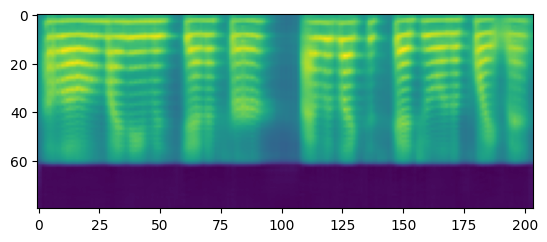

In [ ]:
plt.figure()
plt.imshow(spectrogram.T)
plt.show()

Finally, use the vocoder to turn the spectrogram into sound.

In [ ]:
with torch.no_grad():
    speech = vocoder(spectrogram)

In [ ]:
from IPython.display import Audio
Audio(speech.numpy(), rate=16000)

In [ ]:
import soundfile as sf
sf.write("output.wav", speech.numpy(), samplerate=16000)

## **Classification Tasks for the Harper Valley Bank dataset**


In this section, we build classifiers for the harper-valley dataset. In particular, we build:
- a multi-class classifier for categorising each conversation in the dataset according to its intent, using a Logistic regression model and a pre-trained Transformer model;
- a multi-label classifier for categorising each utterance of every conversation in the dataset according to its dialogue-action, using a pre-trained Transformer model.
- a multi-class classifier for categorising each utterance of every conversation in the dataset according to its emotional valence, using a pre-trained Transformer model.


### Prepare the environment


In [ ]:
import torch
import numpy as np
import re
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import Dataset, DatasetDict
import evaluate

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type != 'cuda':
    raise SystemError('GPU device not found')

Get the data

In [ ]:
metadata = pd.read_csv('Metadata.csv')
transcript_data = pd.read_csv('TranscriptDB.csv')

Clean the data by removing noise and unknown symbols from the human transcription

In [ ]:
transcript_data_sorted = transcript_data.sort_values(by=['index'])

# The unique words included in the conversations which don't have a specific meaning, for example [noise] [cough] ecc
unique_words = set(word for sublist in transcript_data_sorted['human_transcript'].str.findall(r'\[([^\]]+)\]').dropna() for word in sublist)

print(unique_words)

pattern = r'(\[(' + '|'.join(unique_words) + r')\])|\<unk\>'

# Substitute the unique words and the <unk> symbols in each conversation with the empty '' string
transcript_data_sorted['human_transcript'] = transcript_data_sorted['human_transcript'].replace(to_replace=pattern, value='', regex=True).str.strip()

# Remove frome the dataframe the rows for wich the human_transcript is empty
transcript_data_sorted.drop(transcript_data_sorted[transcript_data_sorted['human_transcript'] == ''].index, inplace=True)
transcript_data_sorted = transcript_data_sorted.dropna(subset=['human_transcript'])


{'unintelligible', 'baby', 'music', 'kids', 'noise', 'ringing', 'dogs', 'laughter', 'cough'}


### Classification of each conversation according to its intent

Obtain the conversations by merging the transcript and the metadata dataframes

In [ ]:
transcript_data_grouped_by_id = transcript_data_sorted.groupby('identifier')['human_transcript'].apply(list)
data = metadata.merge(transcript_data_grouped_by_id, on='identifier', how='left')
data.head(10)

,identifier,intent,human_transcript
0,71c19464f839442b,schedule appointment,[hello this is harper valley national bank my ...
1,ef07f78c8bda41c5,transfer money,[hello this is harper valley national bank my ...
2,caf6ec7f86a9410c,transfer money,[hello this is harper valley national bank my ...
3,7e3285db4e354e0b,get branch hours,[hello this is harper valley national bank my ...
4,86d619fb1bfe45e4,schedule appointment,[hello this is harper valley national bank my ...
5,456cb5e3069040bc,replace card,[hello this is harper valley national bank my ...
6,ebdc2700b6524a53,transfer money,[hello this is harper valley national bank my ...
7,d7084d2e23c64024,check balance,[hello this is harper valley national bank my ...
8,76bad60a75bc493d,transfer money,[hello this is harper valley national bank my ...
9,ce135386e8494370,pay bill,[hello this is have her valley national bank m...


Get the conversations and the intents

In [ ]:
conversations = data['human_transcript'].tolist()
intents = data["intent"].tolist()

categories = list(set(intents))

In [ ]:
for i in range(10) :
  print(conversations[i])
  print(intents[i])
  print("\n\n")

['hello this is harper valley national bank my name is linda how can i help you today', 'hello uhm my name is john', 'jones', 'and i was wondering um can i schedule an appointment', 'what day would you like for your appointment', "um let's see uh can we do thursday", 'what time would you like for your appointment', "uh let's do eight a m", 'your appointment has been scheduled for thursday at eight am is there anything else i can help you with', "no that's everything i needed thank you very much", 'thank you for calling have a great day', 'thank you you too bye']
schedule appointment



['hello this is harper valley national bank my name is patricia', 'how can i help you today', 'hi my name is michael smith i would like to transfer money between my accounts', 'what is the transfer amount', 'one hundred and thirty two dollars', 'and what is the source account', 'from my checking account', 'and what is the destination account', 'to my savings account', 'one hundred and thirty two dollars 

Let's compute the occurrences of the classes

In [ ]:
counts = Counter(intents)
counts

Counter({'schedule appointment': 178,
         'transfer money': 170,
         'get branch hours': 190,
         'replace card': 187,
         'check balance': 203,
         'pay bill': 180,
         'order checks': 179,
         'reset password': 159})

The plot below shows that there is a relatively even distribution of conversations across the categories:

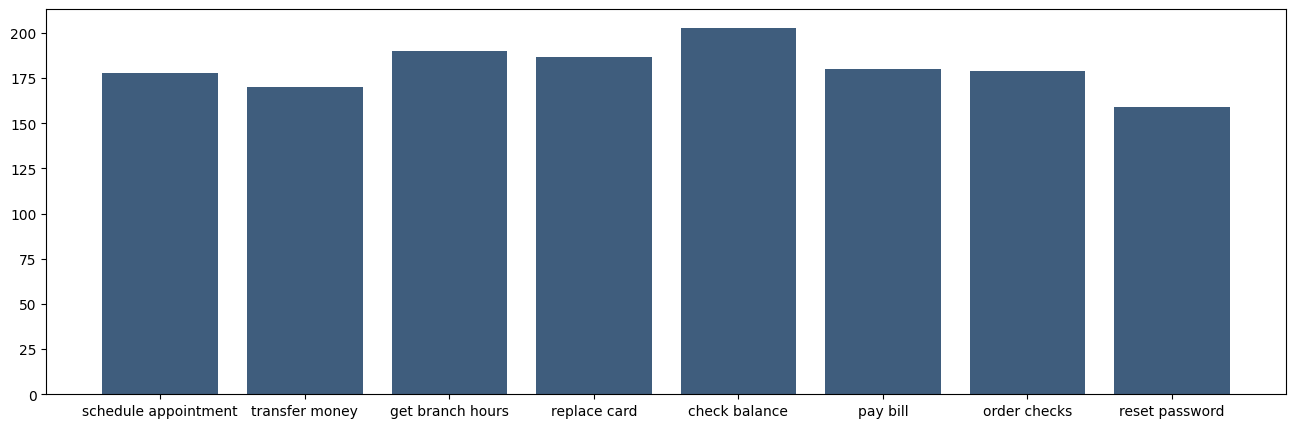

In [ ]:
plt.figure(figsize=(16,5))
plt.bar(counts.keys(), counts.values(), color="#3F5D7D");

Split the data in training, validation and testing

In [ ]:
temp_x, test_x, temp_y, test_y = train_test_split(conversations, intents, test_size=0.2)
train_x, valid_x, train_y, valid_y = train_test_split(temp_x, temp_y, test_size=0.2)

#### 1) Linear model training and evaluation

##### Importing the embedding model and preprocessing data

We embed the conversations using the wiki embedding model

In [ ]:
import gensim.downloader as api
import re
import string

regex = '[' + string.punctuation + ']'
model_wiki = api.load("glove-wiki-gigaword-50")

[==================================================] 100.0% 66.0/66.0MB downloaded


In [ ]:
def vectorize(docs, embedding_model=model_wiki, useSum=True):
    vectors = np.zeros((len(docs),50))
    for i in range(len(docs)):
        doc = re.sub('noise', '', docs[i])
        doc = re.sub('unk', '', doc)
        tokens = re.sub(regex, '', doc.lower()).split()
        embeddings = [embedding_model.get_vector(token) for token in tokens if token in embedding_model]
        if (len(embeddings) > 0):
            if (useSum):
                vectors[i] = sum(embeddings)
            else:
                vectors[i] = np.mean(embeddings, axis=0)
    return vectors

In [ ]:
train_x_vector = vectorize(train_x)
val_x_vector = vectorize(valid_x)
test_x_vector = vectorize(test_x)

##### Creating and Training the model

We define a Logistic Regression model and we fit the vectorized training data

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression().fit(train_x_vector, train_y)

##### Evaluating the model on the test set

In [ ]:
y_pred = lr_model.predict(test_x_vector)

print(classification_report(test_y, y_pred, target_names=categories))

                      precision    recall  f1-score   support

schedule appointment       1.00      0.98      0.99        46
        order checks       1.00      1.00      1.00        31
    get branch hours       1.00      0.97      0.99        36
       check balance       1.00      1.00      1.00        40
        replace card       1.00      1.00      1.00        30
            pay bill       1.00      1.00      1.00        35
      reset password       0.97      1.00      0.99        35
      transfer money       0.97      1.00      0.99        37

            accuracy                           0.99       290
           macro avg       0.99      0.99      0.99       290
        weighted avg       0.99      0.99      0.99       290



The Logistic regression model has already almost optimal performance

#### 2) Pre-trained Transformer model training and evaluation

##### Creating a model and preprocessing data

We use the distilbert model

In [ ]:
model_name = 'distilbert-base-uncased'

In [ ]:
bert = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(categories))

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Move model to GPU

In [ ]:
bert = bert.to(device)

Load the tokenizer

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Preprocess the training, validation and test data using the transformer's data set API

In [ ]:
label_encoder = LabelEncoder()
label_encoder.fit(categories)

LabelEncoder()

In [ ]:
train_data = [{'text': ' - '.join(txt), 'label': label_encoder.transform([lbl])[0]} for txt, lbl in zip(train_x, train_y)]
val_data = [{'text': ' - '.join(txt), 'label': label_encoder.transform([lbl])[0]} for txt, lbl in zip(valid_x, valid_y)]
test_data = [{'text': ' - '.join(txt), 'label': label_encoder.transform([lbl])[0]} for txt, lbl in zip(test_x, test_y)]

In [ ]:
train_data[0]

{'text': 'hello this is harper valley national bank my name is linda how can i help you today - hi my name is james wilson what are the local branch hours - um so the branch hours are nine thirty a m to five p m - is there anything else i can help you with - um no that was it thank you - thank you for calling have a great day - you too',
 'label': 1}

Convert the data sets into the Huggingface data set API format

In [ ]:
train_data = Dataset.from_list(train_data)
val_data = Dataset.from_list(val_data)
test_data = Dataset.from_list(test_data)

Create a container with all the splits of the data set


In [ ]:
data = DatasetDict()
data['train'] = train_data
data['validation'] = val_data
data['test'] = test_data

Use the tokenizer to convert the input strings into sequences of tokens

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding=True, truncation=True)

tokenized_data = data.map(tokenize_function, batched=True)

Map:   0%|          | 0/924 [00:00<?, ? examples/s]

Map:   0%|          | 0/232 [00:00<?, ? examples/s]

Map:   0%|          | 0/290 [00:00<?, ? examples/s]

##### Training the model



Prepare training arguments

In [ ]:
training_args = TrainingArguments(
    output_dir='./conversation_intent_classification',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    eval_strategy="epoch",
)

In [ ]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    acc = accuracy_score(labels, predictions)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

Build the trainer using the Huggingface trainer API

In [ ]:
trainer = Trainer(
    model=bert,
    args=training_args,
    train_dataset=tokenized_data['train'],
    eval_dataset=tokenized_data['validation'],
    compute_metrics=compute_metrics
)

Run the training process



In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.017051,1.000000,1.000000,1.000000,1.000000
2,No log,0.006536,1.000000,1.000000,1.000000,1.000000
3,No log,0.005210,1.000000,1.000000,1.000000,1.000000


TrainOutput(global_step=348, training_loss=0.22651071658079652, metrics={'train_runtime': 36.7939, 'train_samples_per_second': 75.339, 'train_steps_per_second': 9.458, 'total_flos': 218048108737536.0, 'train_loss': 0.22651071658079652, 'epoch': 3.0})

##### Evaluating the model



First we run the evaluation process included with the trainer

In [ ]:
trainer.evaluate()

{'eval_loss': 0.005209889728575945,
 'eval_accuracy': 1.0,
 'eval_f1': 1.0,
 'eval_precision': 1.0,
 'eval_recall': 1.0,
 'eval_runtime': 0.7202,
 'eval_samples_per_second': 322.115,
 'eval_steps_per_second': 40.264,
 'epoch': 3.0}

Then we get the predictions on the test set

In [ ]:
preds = trainer.predict(tokenized_data['test'])


Convert predicted logits to classes using the $\mathrm{argmax}$ operator

In [ ]:
y_pred = torch.argmax(torch.tensor(preds.predictions), dim=1).numpy()

Print the classification report

In [ ]:
print(classification_report(label_encoder.transform(test_y), y_pred, target_names=categories))

                      precision    recall  f1-score   support

schedule appointment       1.00      0.98      0.99        48
            pay bill       1.00      1.00      1.00        32
      reset password       0.97      1.00      0.98        29
        order checks       1.00      1.00      1.00        32
      transfer money       1.00      1.00      1.00        35
        replace card       1.00      1.00      1.00        40
    get branch hours       1.00      1.00      1.00        40
       check balance       1.00      1.00      1.00        34

            accuracy                           1.00       290
           macro avg       1.00      1.00      1.00       290
        weighted avg       1.00      1.00      1.00       290



We  have a look at the test examples on which the model made the worst predictions:

Compute loss

In [ ]:
loss = torch.nn.functional.cross_entropy(torch.tensor(preds.predictions), torch.tensor(preds.label_ids), reduction='none')

Identify the index of the element with the highest loss

In [ ]:
index_of_instance = torch.argmax(loss).item()
index_of_instance

250

Loss of the corresponding sample

In [ ]:
loss[index_of_instance].item()

2.629976511001587

Predicted class and target class

In [ ]:
print(f'Target class:    {intents[index_of_instance]}')
print(f'Predicted class: {label_encoder.inverse_transform([y_pred[index_of_instance]])[0]}')

Target class:    check balance
Predicted class: order checks


Print out the conversation with the top loss

In [ ]:
print(conversations[index_of_instance])

['hello this is harper valley national bank my name is robert', 'how can i help you today', 'hi my name is james dunes', 'i need to check my account balance', 'which account would you like to check', 'my checking account', 'your checking account balance is one hundred and twenty one dollars is there anything else i can help you with', 'no', 'thank you for calling have a great day']


##### Saving and Loading the model

We save the predictor for later use

In [ ]:
bert.save_pretrained('./conversation_intent_classification')

In [ ]:
bert = AutoModelForSequenceClassification.from_pretrained('./conversation_intent_classification').to(device)

### Classification of each utterance according to its dialogue actions

Get the utterances and their corresponding dialog_acts labels

In [ ]:
utterances = transcript_data_sorted['human_transcript'].tolist()
dialog_acts = transcript_data_sorted['dialog_acts'].tolist()

# All the classes are enclosed in single quotes
pattern = r"'([^']+)'"


for i in range(len(dialog_acts)):
  dialog_acts[i] = re.findall(pattern, dialog_acts[i])

In [ ]:
for i in range(6000,6010) :
  print(utterances[i])
  print(dialog_acts[i])
  print("\n\n")

four four zero
['gridspace_response', 'gridspace_data_response']



i need to check my account balance
['gridspace_response', 'gridspace_problem_description']



um eight a m
['gridspace_data_communication', 'gridspace_data_response']



what is your address
['gridspace_data_question']



hi my name is linda wilson
['gridspace_greeting', 'gridspace_data_response']



thank you so much
['gridspace_thanks']



and i would like to schedule an appointment
['gridspace_problem_description', 'gridspace_data_response']



sure i can help you with that what is the company name
['gridspace_data_question']



hi my name is linda jones
['gridspace_greeting', 'gridspace_data_response']



my address is
['gridspace_data_response', 'gridspace_problem_description']





Let's compute the occurrences of the classes

In [ ]:
flattened_dialog_acts = [
    d
    for ds in dialog_acts
    for d in ds
]

counts = Counter(flattened_dialog_acts)

classes = list(set(flattened_dialog_acts))

In [ ]:
classes

['gridspace_greeting',
 'gridspace_data_communication',
 'gridspace_filler_disfluency',
 'gridspace_bear_with_me',
 'gridspace_confirm_data',
 'gridspace_closing',
 'gridspace_data_question',
 'gridspace_data_response',
 'gridspace_acknowledgement',
 'gridspace_thanks',
 'gridspace_problem_description',
 'gridspace_open_question',
 'gridspace_other',
 'gridspace_response',
 'gridspace_procedure_explanation',
 'gridspace_yes_response']

The plot below shows that there is an unbalanced distribution of the dialog actions

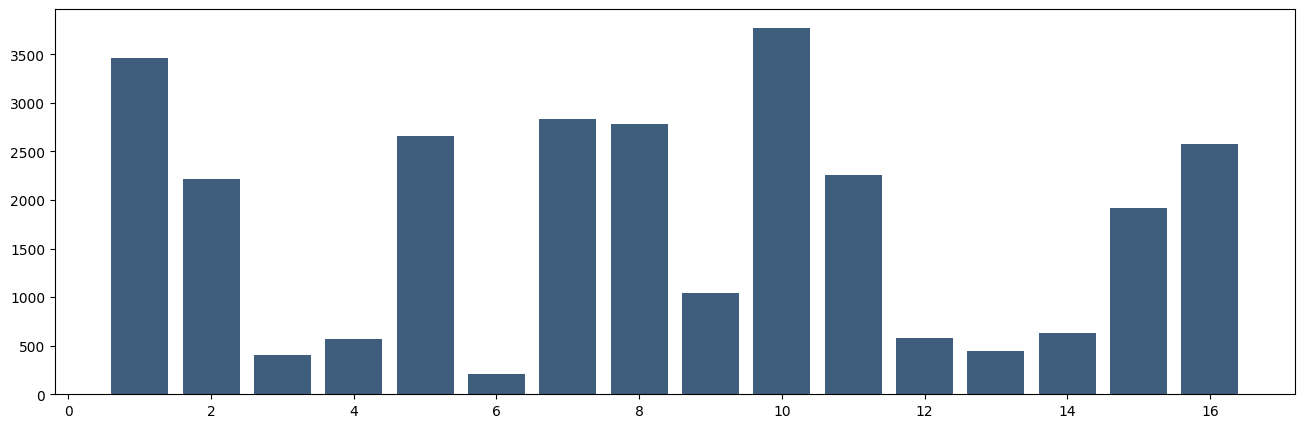

In [ ]:
plt.figure(figsize=(16,5))
plt.bar(range(1,len(counts.keys())+1), counts.values(), color="#3F5D7D");

Split the data in training, validation and testing

In [ ]:
temp_x, test_x, temp_y, test_y = train_test_split(utterances, dialog_acts, test_size=0.2)
train_x, valid_x, train_y, valid_y = train_test_split(temp_x, temp_y, test_size=0.2)

### Creating a model and preprocessing data

We use the distilbert model

In [ ]:
class2id = {class_:id for id, class_ in enumerate(classes)}
id2class = {id:class_ for class_, id in class2id.items()}

In [ ]:
model_name = 'distilbert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(

   model_name, num_labels=len(classes),
           id2label=id2class, label2id=class2id,
                       problem_type = "multi_label_classification")

model = model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Preprocess the training, validation and test data using the transformer's data set API and preprocess the labels so that they are vector of binary values (utterance has label or not for each label)

In [ ]:
def get_labels_vector(all_labels):
    labels = [0. for i in range(len(classes))]
    for label in all_labels:
          label_id = class2id[label]
          labels[label_id] = 1.

    return labels

train_data = [{'text': txt, 'label': get_labels_vector(lbl)} for txt, lbl in zip(train_x, train_y)]
val_data = [{'text': txt, 'label': get_labels_vector(lbl)} for txt, lbl in zip(valid_x, valid_y)]
test_data = [{'text': txt, 'label': get_labels_vector(lbl)} for txt, lbl in zip(test_x, test_y)]

Convert the data sets into the Huggingface data set API format

In [ ]:
train_data = Dataset.from_list(train_data)
val_data = Dataset.from_list(val_data)
test_data = Dataset.from_list(test_data)

Create a container with all the splits of the data set

In [ ]:
data = DatasetDict()
data['train'] = train_data
data['validation'] = val_data
data['test'] = test_data

Use the tokenizer to convert the input strings into sequences of tokens

In [ ]:
def preprocess_function(example):
    return tokenizer(example['text'], truncation=True, padding=True)


tokenized_dataset = data.map(preprocess_function, batched=True)

Map:   0%|          | 0/12352 [00:00<?, ? examples/s]

Map:   0%|          | 0/3088 [00:00<?, ? examples/s]

Map:   0%|          | 0/3861 [00:00<?, ? examples/s]

#### Training the model

Define the training arguments

In [ ]:
training_args = TrainingArguments(
   output_dir='./utterances_dialogue_acts_classification',
   learning_rate=2e-5,
   per_device_train_batch_size=3,
   per_device_eval_batch_size=3,
   num_train_epochs=3,
   weight_decay=0.01,
   eval_strategy="epoch",
   save_strategy = "epoch"
)


Define the metrics to compute. In this case the metric are computed by flattening the predictions

In [ ]:
clf_metrics = evaluate.combine(["accuracy", "f1", "precision", "recall"])

def sigmoid(x):
   return 1/(1 + np.exp(-x))

def compute_metrics(eval_pred):

   predictions, labels = eval_pred
   predictions = sigmoid(predictions)
   predictions = (predictions > 0.5).astype(int).reshape(-1)
   return clf_metrics.compute(predictions=predictions, references=labels.astype(int).reshape(-1))


Build the trainer using the Huggingface trainer API

In [ ]:
trainer = Trainer(

   model=model,
   args=training_args,
   train_dataset=tokenized_dataset["train"],
   eval_dataset=tokenized_dataset["validation"],
   tokenizer=tokenizer,
   compute_metrics=compute_metrics,
)


Run the training process

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.137300,0.137041,0.946891,0.665050,0.789633,0.574421
2,0.133700,0.134131,0.948227,0.679127,0.787605,0.596913
3,0.118400,0.132542,0.948652,0.681081,0.792105,0.597354


TrainOutput(global_step=12354, training_loss=0.13882998855094297, metrics={'train_runtime': 755.1835, 'train_samples_per_second': 49.069, 'train_steps_per_second': 16.359, 'total_flos': 417777869460384.0, 'train_loss': 0.13882998855094297, 'epoch': 3.0})

#### Evaluating the model

First we run the evaluation process included in the trainer

In [ ]:
trainer.evaluate()

{'eval_loss': 0.13254231214523315,
 'eval_accuracy': 0.9486520401554405,
 'eval_f1': 0.681081081081081,
 'eval_precision': 0.7921052631578948,
 'eval_recall': 0.597353914002205,
 'eval_runtime': 10.6934,
 'eval_samples_per_second': 288.777,
 'eval_steps_per_second': 96.321,
 'epoch': 3.0}

Then we get the predictions on the test set

In [ ]:
preds = trainer.predict(tokenized_dataset['test'])


In [ ]:
predictions, labels = preds.predictions, preds.label_ids
predictions = sigmoid(predictions)
predictions = (predictions > 0.5).astype(int)

In [ ]:
labels.shape, predictions.shape, len(test_y)

((3861, 16), (3861, 16), 3861)

Print the two accuracies: ratio of example that matches perfectly (Subset Accuracy) and accurracy after flattening the predictions and the true labels

In [ ]:
true_labels = [get_labels_vector(all_labels) for all_labels in test_y]

In [ ]:
print(f"Subset Accuracy : {accuracy_score(true_labels, predictions)}")
print(f"Flattened prediction Accuracy : {accuracy_score(np.array(true_labels).reshape(-1), predictions.reshape(-1))}")

Subset Accuracy : 0.4687904687904688
Flattened prediction Accuracy : 0.9494140119140119


In [ ]:
print(classification_report(true_labels, predictions, target_names=classes, zero_division = 0.0))

                                 precision    recall  f1-score   support

             gridspace_greeting       0.90      0.92      0.91       672
   gridspace_data_communication       0.00      0.00      0.00       116
    gridspace_filler_disfluency       0.90      0.21      0.35        84
         gridspace_bear_with_me       0.92      0.57      0.71        40
         gridspace_confirm_data       0.56      0.07      0.13       134
              gridspace_closing       0.92      0.91      0.91       531
        gridspace_data_question       0.91      0.74      0.81       584
        gridspace_data_response       0.63      0.67      0.65       562
      gridspace_acknowledgement       0.83      0.65      0.73       235
               gridspace_thanks       0.85      0.55      0.67       394
  gridspace_problem_description       0.68      0.54      0.60       524
        gridspace_open_question       0.88      0.84      0.86       442
                gridspace_other       0.73      0.

It seems that the model fail to identify some classes

#### Saving the model


We save the predictor for later use

In [ ]:
model.save_pretrained('./utterances_dialogue_acts_classification')

### Emotional Valence Classification

Get the utterances and their corresponding emotional valence values

In [ ]:
utterances = transcript_data_sorted['human_transcript'].tolist()
emotion_positive = transcript_data_sorted['emotion_positive'].tolist()
emotion_negative = transcript_data_sorted['emotion_negative'].tolist()
emotion_neutral = transcript_data_sorted['emotion_neutral'].tolist()
emotions_values = [[positive, neutral, negative] for positive, neutral, negative in zip(emotion_positive, emotion_neutral, emotion_negative)]

emotions = ["Positive", "Neutral", "Negative"]

From the details below, we observse that there is a soft assignment of the utterances to each emotional valence

In [ ]:
for i in range(5000,5010) :
  print(utterances[i])
  print(f" Positive : {emotions_values[i][0]}")
  print(f" Neutral : {emotions_values[i][1]}")
  print(f" Negative : {emotions_values[i][2]}")
  print("\n\n")

uh monday
 Positive : 0.200918510556221
 Neutral : 0.5205568671226501
 Negative : 0.2785246074199676



what is the source account
 Positive : 0.109798364341259
 Neutral : 0.4779114723205566
 Negative : 0.4122901558876037



uhm one hundred and fifty three dollars
 Positive : 0.3424000442028045
 Neutral : 0.5429161190986633
 Negative : 0.1146838441491127



what is the source account
 Positive : 0.1187124401330947
 Neutral : 0.4962612688541412
 Negative : 0.3850263059139251



alright and what is the source account
 Positive : 0.2125709354877472
 Neutral : 0.555343747138977
 Negative : 0.2320853620767593



four three five
 Positive : 0.2400891780853271
 Neutral : 0.5532033443450928
 Negative : 0.2067075222730636



saturday
 Positive : 0.1631856262683868
 Neutral : 0.4961819648742676
 Negative : 0.3406323790550232



i'm sorry what did you say
 Positive : 0.1008231416344642
 Neutral : 0.3955625891685486
 Negative : 0.5036142468452454



now you said you lost your credit card is that c

Split the data in training, validation and testing

In [ ]:
temp_x, test_x, temp_y, test_y = train_test_split(utterances, emotions_values, test_size=0.2)
train_x, valid_x, train_y, valid_y = train_test_split(temp_x, temp_y, test_size=0.2)

#### Creating a model and preprocessing data

We use the distilbert model

In [ ]:
model_name = 'distilbert-base-uncased'

tokenizer_e = AutoTokenizer.from_pretrained(model_name)

emotional_valence_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=len(emotions))

emotional_valence_model = emotional_valence_model.to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Preprocess the training, validation and test data using the transformer's data set API

In [ ]:
train_data = [{'text': txt, 'label': lbl} for txt, lbl in zip(train_x, train_y)]
val_data = [{'text': txt, 'label': lbl} for txt, lbl in zip(valid_x, valid_y)]
test_data = [{'text': txt, 'label': lbl} for txt, lbl in zip(test_x, test_y)]

Convert the data sets into the Huggingface data set API format

In [ ]:
train_data = Dataset.from_list(train_data)
val_data = Dataset.from_list(val_data)
test_data = Dataset.from_list(test_data)

Create a container with all the splits of the data set

In [ ]:
data = DatasetDict()
data['train'] = train_data
data['validation'] = val_data
data['test'] = test_data

Use the tokenizer to convert the input strings into sequences of tokens

In [ ]:
def preprocess_function_e(example):
    return tokenizer_e(example['text'], truncation=True, padding=True)


tokenized_dataset = data.map(preprocess_function_e, batched=True)

Map:   0%|          | 0/12352 [00:00<?, ? examples/s]

Map:   0%|          | 0/3088 [00:00<?, ? examples/s]

Map:   0%|          | 0/3861 [00:00<?, ? examples/s]

#### Training the model

Define the training arguments

In [ ]:
training_args = TrainingArguments(
   output_dir='./utterances_emotional_valence_classification',
   learning_rate=2e-5,
   per_device_train_batch_size=3,
   per_device_eval_batch_size=3,
   num_train_epochs=2,
   weight_decay=0.01,
   eval_strategy="epoch",
   save_strategy = "epoch"
)


Build the trainer using the Huggingface trainer API

In [ ]:
trainer = Trainer(

   model=emotional_valence_model,
   args=training_args,
   train_dataset=tokenized_dataset["train"],
   eval_dataset=tokenized_dataset["validation"],
   tokenizer=tokenizer_e
)


Run the training process

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.548500,0.549106
2,0.548500,0.548251


TrainOutput(global_step=8236, training_loss=0.5497478727810357, metrics={'train_runtime': 528.2679, 'train_samples_per_second': 46.764, 'train_steps_per_second': 15.591, 'total_flos': 278644708983942.0, 'train_loss': 0.5497478727810357, 'epoch': 2.0})

#### Evaluating the model

Since there is a soft-assigment of the labels, we use the cross-entropy loss as the main metric to evaluate the model

First we run the evaluation process included in the trainer

In [ ]:
trainer.evaluate()

{'eval_loss': 0.5482513904571533,
 'eval_runtime': 9.2079,
 'eval_samples_per_second': 335.363,
 'eval_steps_per_second': 111.86,
 'epoch': 2.0}

Then we get the predictions on the test set

In [ ]:
y_pred = trainer.predict(tokenized_dataset['test'])
y_pred_max = torch.argmax(torch.tensor(y_pred.predictions), dim=1).numpy()

In [ ]:
def softmax(y_pred):
   sum = np.sum([np.exp(y_pred[i]) for i in range(y_pred.shape[0])])
   return [np.exp(y_pred[i])/sum for i in range(y_pred.shape[0])]

def cross_entropy_loss(y_true, y_pred):
    y_pred = [softmax(y_pred[i]) for i in range(y_pred.shape[0])]
    # Ensure the predictions are between 0 and 1
    y_pred = np.clip(y_pred, 1e-15, 1 - 1e-15)
    # Compute the cross-entropy loss
    loss = -np.sum(y_true * np.log(y_pred), axis=1)
    # Return the mean loss
    return np.average(loss)

In [ ]:
loss = cross_entropy_loss(np.array(test_y), torch.tensor(y_pred.predictions).numpy())
print("Cross-Entropy Loss:", loss)

Cross-Entropy Loss: 0.9580424891958738


We can also pick the max of both the true assignment and the prediction and compute the standard metrics (accuracy, f1-score ecc)

In [ ]:
y_test_max = np.argmax(test_y, axis=1)

print(classification_report(y_test_max, y_pred_max, target_names=emotions))

              precision    recall  f1-score   support

    Positive       0.93      0.94      0.94      1610
     Neutral       0.94      0.94      0.94      2157
    Negative       0.74      0.52      0.61        94

    accuracy                           0.93      3861
   macro avg       0.87      0.80      0.83      3861
weighted avg       0.93      0.93      0.93      3861



#### Saving the model

We save the predictor for later use

In [ ]:
emotional_valence_model.save_pretrained('./utterances_emotional_valence_classification')

## **Voice Interactive System**

In this section, we put everything together to build a system which simulates calls to the bank.

In particular, the system takes as input a recorded audio question from the user (caller) and run the question through the pipeline composed of the ASR model, the chatbot and the text-to-speech model to generate a recorded audio response.

This interaction stops when the user stop asking question or when the chatbot predict the end of conversation (usually when it predicts 'bye' or 'have a great day')

### Initial imports

In [ ]:
import numpy as np
import torch
import datasets

In [ ]:
from torch.nn.utils.rnn import pad_sequence
from IPython.display import display, HTML, Audio
import IPython.display as ipd
from speechbrain.inference.classifiers import EncoderClassifier
import soundfile as sf
from google.colab.output import eval_js
from base64 import b64decode
from scipy.io.wavfile import read as wav_read
import io
import torchaudio
import librosa
import ffmpeg

from transformers import (
    AutoModelWithLMHead,
    AutoTokenizer,
    Wav2Vec2Processor,
    Wav2Vec2ForCTC,
    SpeechT5Processor,
    SpeechT5ForTextToSpeech,
    SpeechT5HifiGan,
    AutoModelForSequenceClassification
)

### Load the models

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Load the wav2vec model and processor
wav2vec_model_name = './ASR_fine_tune_HarperValleyBank'
wav2vec_processor = Wav2Vec2Processor.from_pretrained(wav2vec_model_name)
wav2vec_model = Wav2Vec2ForCTC.from_pretrained(wav2vec_model_name)

# Load the DialogGPT model and tokenizer
dialoggpt_model_name = './chatbot-3'
dialoggpt_tokenizer = AutoTokenizer.from_pretrained(dialoggpt_model_name)
dialoggpt_model = AutoModelWithLMHead.from_pretrained(dialoggpt_model_name)

# Load the SpeechT5 model and processor
speecht5_model_name = './text-to-speech_fine_tune_HarperValleyBank'
speecht5_processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
speecht5_model = SpeechT5ForTextToSpeech.from_pretrained(speecht5_model_name)

# Load the vocoder to obtain the audio wave from the spectogram
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")



/usr/local/lib/python3.10/dist-packages/transformers/models/auto/modeling_auto.py:1712: FutureWarning:

The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.



### Create the pipeline stages

Record the question

In [ ]:
AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

Automatic Speech Recognition

In [ ]:
def transcribe_audio(waveform, sample_rate):
    inputs = wav2vec_processor(waveform, sampling_rate=sample_rate, return_tensors="pt").input_values
    logits = wav2vec_model(inputs).logits
    predicted_ids = torch.argmax(logits, dim=-1)
    transcription = wav2vec_processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]
    return transcription

Chatbot

In [ ]:
def sample_to_string(sample, eos_token):
    # Join strings
    dialogue = eos_token.join(f" {utterance['speaker_role']}: {utterance['text']} " for utterance in sample)
    # Build the dialogue string
    dialogue_string = f"{dialogue}{eos_token}"

    return dialogue_string

def generate_response(input_string):
    input_encoding = dialoggpt_tokenizer(input_string, return_tensors="pt")
    output_ids = dialoggpt_model.generate(input_encoding.input_ids, num_beams=8, max_new_tokens=35, pad_token_id=dialoggpt_tokenizer.eos_token_id, early_stopping = True)
    chatbot_response = dialoggpt_tokenizer.decode(output_ids[0, input_encoding.input_ids.size(1):], skip_special_tokens=True)
    return chatbot_response

Text-to-Speech

In [ ]:
def text_to_speech(text, speaker_embeddings):
    inputs = speecht5_processor(text=text, return_tensors="pt")
    spectrogram = speecht5_model.generate_speech(inputs.input_ids, speaker_embeddings)
    return spectrogram


Play response

In [ ]:
def save_audio(spectrogram, output_path):
    with torch.no_grad():
      speech = vocoder(spectrogram)
    sf.write(output_path, speech.numpy(), samplerate=16000)

def play_audio(spectrogram):
    with torch.no_grad():
      speech = vocoder(spectrogram)

    display(Audio(speech.cpu().numpy(), rate=16000, autoplay=True))


### Interaction Loop

In [ ]:
dialogue = [{'speaker_role': 'agent', 'text': 'hello this is harper valley national bank my name is elizabeth how can i help you today'}]
speaker_embeddings = torch.load("./speaker_embeddings")
print(speaker_embeddings.shape)
spectrogram = text_to_speech(dialogue[0]['text'], speaker_embeddings)
play_audio(spectrogram)

output_path = "output.wav"

torch.Size([1, 512])


In [ ]:
def main():
    while True:

        '''SPEECH-TO-TEXT'''

        waveform, sample_rate = get_audio()
        sf.write(output_path, waveform, samplerate=sample_rate)
        waveform, sample_rate = librosa.load(output_path, sr=16000)
        transcription = transcribe_audio(waveform, sample_rate)
        print(f"User: {transcription}")


        '''CHATBOT'''
        # Append message to dialogue history
        dialogue.append(
            {'speaker_role': 'caller', 'text': transcription.lower()}
        )
        # Convert dialogue to string
        input_string = sample_to_string(dialogue, dialoggpt_tokenizer.eos_token)

        response = generate_response(input_string)

        # Crop initial speaker token
        response = response[7:]
        # Append chatbot response to dialogue history
        dialogue.append(
            {'speaker_role': 'agent', 'text': response}
        )
        print(f"Agent: {response}")


        '''TEXT-TO-SPEECH'''
        spectrogram = text_to_speech(response, speaker_embeddings)
        play_audio(spectrogram)

        if ("bye" in response or "have a great day" in response):
          break

        user_input = input("Do you want to ask another question? (yes/no): ").strip().lower()
        if user_input != 'yes':
            break


When you run this cell, it will start recording the first question of the caller

In [ ]:
dialogue = [{'speaker_role': 'agent', 'text': 'hello this is harper valley national bank my name is elizabeth how can i help you today'}]
main()

User: hi my name is john and i would like to transfer morny
Agent:  what is the transfer amount 


Do you want to ask another question? (yes/no): yes


User: a hundred dolars
Agent:  what is the source account 


Do you want to ask another question? (yes/no): yes


User: my checking acount
Agent:  what is the destination account 


Do you want to ask another question? (yes/no): yes


User: my savings acount
Agent:  is there anything else i can help you with 


Do you want to ask another question? (yes/no): yes


User: no that's al thank you
Agent:  thank you for calling have a great day 


We can also use the classifier to predict the intent of the conversation

In [ ]:
bert = AutoModelForSequenceClassification.from_pretrained('./conversation_intent_classification').to(device)

In [ ]:
categories = ['schedule appointment','pay bill','reset password','order checks','transfer money','replace card','get branch hours', 'check balance']
label_encoder1 = LabelEncoder()
label_encoder1.fit(categories)

LabelEncoder()

In [ ]:
@torch.no_grad()
def predict(text):
    input_encodings = tokenizer(text, return_tensors='pt').to(device)
    outputs = bert(**input_encodings)

    lbl = torch.argmax(outputs.logits).item()
    print(outputs.logits)

    return label_encoder1.inverse_transform([lbl])

In [ ]:
sample_text = ' - '.join([u['text'] for u in dialogue])
print(sample_text)
print(predict(sample_text))

hello this is harper valley national bank my name is elizabeth how can i help you today - hi my name is john and i would like to transfer morny -  what is the transfer amount  - a hundred dolars -  what is the source account  - my checking acount -  what is the destination account  - my savings acount -  is there anything else i can help you with  - no that's al thank you -  thank you for calling have a great day 
tensor([[-0.7340, -1.7260, -1.7210, -0.7623, -1.2459, -1.5626, -1.0829,  5.6293]],
       device='cuda:0')
['transfer money']
